## Parcial Final ML

### Presentado por: Angel Pineda

## EDA

* Se importan algunas librerias necesarias para el EDA.

In [94]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor



### Fraud Detection

Los datos proceden de transacciones reales de comercio electrónico de Vesta y contienen una amplia gama
de características, desde el tipo de dispositivo hasta las características del producto. El objetivo principal es
mejorar la eficacia de las alertas de transacciones fraudulentas para millones de personas en todo el mundo,
ayudando a cientos de miles de empresas a reducir sus pérdidas por fraude y aumentar sus ingresos. Y, por
supuesto, ahorrará a muchas personas la molestia de los falsos positivos.
* TransactionDT : Intervalo de tiempo a partir de una fecha y hora de referencia
* TransactionAMT : Importe del pago de la transacción en USD
* ProductCD: Código de producto, el producto de cada transacción
* card1 - card6 : Información de la tarjeta de pago, como tipo de tarjeta, categoría de tarjeta, banco
emisor, país, etc.
* addr: Dirección
* dist: Distancia
* P_ and (R_) emaildomain: Dominio de correo electrónico del comprador y del destinatario
* C1-C14 : Recuento, cuántas direcciones se encuentran asociadas a la tarjeta de pago, etc. El significado
real está codificado.
* D1-D15: Intervalo de tiempo, como los días transcurridos entre la transacción anterior, etc.
* M1-M9: Coinciden, como los nombres en la tarjeta y la dirección, etc.
* Vxxx: Vesta ofrece una gran variedad de funciones, como la clasificación, el recuento y otras relaciones
entre entidades.
* DeviceType: Codificada. Información de identidad o conexión de red (IP, ISP, Proxy, etc) o firma digital
* DeviceInfo: Codificada. Información de identidad o conexión de red (IP, ISP, Proxy, etc) o firma digital
* id_12 - id_38: Codificada. Información de identidad o conexión de red (IP, ISP, Proxy, etc) o firma
digital

#### Lectura de dataset

In [95]:
data_transaction = pd.read_csv('train_transaction_new.csv')
data_identity = pd.read_csv('train_identity_new.csv')


* Se reduce el tamaño de los dataframes para optimizar el computo.

In [96]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df

In [97]:
data_transaction =  reduce_mem_usage(data_transaction)
data_identity = reduce_mem_usage(data_identity)

Initial memory usage of dataframe is 351.69 MB/0.34 GB


Memory usage after optimization is: 78.50 MB/0.08 GB
Decreased by 77.7%
Initial memory usage of dataframe is 109.83 MB/0.11 GB
Memory usage after optimization is: 6.94 MB/0.01 GB
Decreased by 93.7%


In [98]:
data_fraud = pd.merge(data_transaction, data_identity, on='TransactionID', how='left')

* Se elimina los dataframes para liberar espacio en memoria

In [99]:
del data_transaction
del data_identity


* Se muestra los primeros 5 valores del dataset, se observa que hay columnas categoricas y numericas, donde la variable a predecir es "isFraud"

In [100]:
data_fraud.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
1        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
2        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
3        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
4  2220x1080  match_status:2      T     F     T      T      mobile   

                      DeviceInfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

In [101]:
data_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float16(375), float32(24), int16(1), int32(2), int8(1)
memory usage: 84.9 MB


In [102]:
data_fraud.describe()

TransactionID      isFraud  TransactionDT  TransactionAmt  \
count   9.999900e+04  99999.00000   9.999900e+04    99999.000000   
mean    3.036999e+06      0.02561   1.135115e+06             NaN   
std     2.886737e+04      0.15797   5.733446e+05             NaN   
min     2.987000e+06      0.00000   8.640000e+04        0.291992   
25%     3.012000e+06      0.00000   6.537475e+05       45.000000   
50%     3.036999e+06      0.00000   1.189336e+06       75.000000   
75%     3.061998e+06      0.00000   1.643436e+06      136.000000   
max     3.086998e+06      1.00000   2.006177e+06     4828.000000   

              card1    card2    card3    card5    addr1    addr2  ...  \
count  99999.000000  98645.0  99996.0  99474.0  90962.0  90962.0  ...   
mean    9878.453325      NaN      NaN      NaN      NaN      NaN  ...   
std     4933.557719      NaN      0.0      0.0      NaN      0.0  ...   
min     1001.000000    100.0    100.0    100.0    100.0     13.0  ...   
25%     6019.000000    215.0    150.0    166.0    204.0     87.0  ...   
50%     9653.000000    387.0    150.0    226.0    299.0     87.0  ...   
75%    14290.000000    514.0    150.0    226.0    330.0     87.0  ...   
max    18395.000000    600.0    229.0    237.0    540.0    102.0  ...   

             id_17         id_18    id_19    id_20   id_21        id_22  \
count  39880.00000  1.298100e+04  39871.0  39866.0  1620.0  1624.000000   
mean           inf           inf      inf      inf     inf    15.515625   
std       25.65625  1.479492e+00      inf      inf     inf     6.054688   
min      100.00000  1.100000e+01    100.0    100.0   100.0    12.000000   
25%      166.00000  1.300000e+01    266.0    222.0   252.0    14.000000   
50%      166.00000  1.300000e+01    352.0    391.0   252.0    14.000000   
75%      166.00000  1.500000e+01    492.0    521.0   576.0    14.000000   
max      229.00000  2.900000e+01    671.0    660.0   853.0    41.000000   

             id_24      id_25      id_26         id_32  
count  1500.000000  1612.0000  1623.0000  2.983800e+04  
mean     13.226562        inf        inf           inf  
std       2.179688   104.0625    31.0625  3.654297e+00  
min      11.000000   100.0000   100.0000  0.000000e+00  
25%      11.000000   272.0000   121.0000  2.400000e+01  
50%      15.000000   321.0000   150.0000  2.400000e+01  
75%      15.000000   381.0000   169.0000  3.200000e+01  
max      25.000000   548.0000   216.0000  3.200000e+01  

[8 rows x 403 columns]

* Se encuentra una gran cantidad de datos faltantes, especialmente en DeviceType y DeviceInfo, se realizará una eliminación de columnas con muchos datos faltantes y luego sera necesario realizar un metodo de imputación de datos faltantes.

In [103]:
data_fraud.isnull().sum()

# Calcular la cantidad de valores nulos en porcentaje para cada columna
porcentaje_nulos = (data_fraud.isnull().sum() / len(data_fraud)) * 100

# 'porcentaje_nulos' ahora contiene el porcentaje de valores nulos para cada columna
print(f'Porcentaje de valores nulos')

print(porcentaje_nulos)

print('')
print(f'Numero de datos faltantes')
print(data_fraud.isnull().sum())

Porcentaje de valores nulos
TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
                    ...    
id_36             59.598596
id_37             59.598596
id_38             59.598596
DeviceType        59.716597
DeviceInfo        63.534635
Length: 434, dtype: float64

Numero de datos faltantes
TransactionID         0
isFraud               0
TransactionDT         0
TransactionAmt        0
ProductCD             0
                  ...  
id_36             59598
id_37             59598
id_38             59598
DeviceType        59716
DeviceInfo        63534
Length: 434, dtype: int64


* Eliminación de Columnas con mas del 30% de datos faltantes, por motivos computacionales. Además, no seria adecuado imputar datos a columnas que tienen más del 30% de datos faltantes, no seria una muestra representativa para encontrar la mediana y moda.

In [104]:
# Establecer un umbral del 50% para eliminar columnas
umbral = 30

# Obtener una lista de columnas que superen el umbral de datos nulos
columnas_a_eliminar = porcentaje_nulos[porcentaje_nulos > umbral].index.tolist()

# Eliminar las columnas que superen el umbral
data_fraud = data_fraud.drop(columnas_a_eliminar, axis=1)


In [105]:
data_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 115 entries, TransactionID to V321
dtypes: category(4), float16(100), float32(7), int16(1), int32(2), int8(1)
memory usage: 23.2 MB


* Se almacena por separado la variable a predecir y las variables independientes.

In [106]:
y_fraud = data_fraud['isFraud']

X_fraud = data_fraud.drop(columns='isFraud') # Se elimina la variable a predecir


* Se realizará una imputación a los datos faltantes.
Se rellenará con la mediana de los datos de la variable en el caso de que se trate de una variable numérica. Para el caso de las variables categóricas se imputará con la moda de la variable.

In [107]:
from sklearn.impute import SimpleImputer

# Identifica las columnas numéricas y categóricas
columnas_numericas = X_fraud.select_dtypes(include=['number']).columns
columnas_categoricas = X_fraud.select_dtypes(include=['category']).columns

# Crea imputadores separados para las columnas numéricas y categóricas
imputador_numericas = SimpleImputer(strategy='median')
imputador_categoricas = SimpleImputer(strategy='most_frequent')

# Ajusta y transforma los imputadores por separado para las columnas numéricas y categóricas
X_fraud[columnas_numericas] = imputador_numericas.fit_transform(data_fraud[columnas_numericas])
X_fraud[columnas_categoricas] = imputador_categoricas.fit_transform(data_fraud[columnas_categoricas])


In [108]:
columnas_categoricas

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain'], dtype='object')

In [109]:
columnas_numericas


Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2',
       'card3', 'card5', 'addr1', 'addr2', 'C1',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=110)

* Ya se han rellenado los datos con la mediana y la moda, y por lo tanto podemos ver que no se encuentran datos nulos.

In [110]:
data_fraud.isnull().sum()

TransactionID      0
isFraud            0
TransactionDT      0
TransactionAmt     0
ProductCD          0
                  ..
V317              11
V318              11
V319              11
V320              11
V321              11
Length: 115, dtype: int64

##### Reduccion de dimensionalidad

* Se separan los datos en numericos y categóricos.

In [111]:
# Separar las características numéricas (si las hay)
X_fraud_num = X_fraud.select_dtypes(include=['int64', 'float64'])

# Separar las características categóricas (si las hay)
X_fraud_cat = X_fraud.select_dtypes(include=['object'])

In [112]:
X_fraud_num.info()
print("")
X_fraud_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 110 entries, TransactionID to V321
dtypes: float64(110)
memory usage: 83.9 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ProductCD      99999 non-null  object
 1   card4          99999 non-null  object
 2   card6          99999 non-null  object
 3   P_emaildomain  99999 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


*Prueba de dependencia de Variables categóricas*

* Aqui se realiza el test chi para determinar que variables categoricas se encuentran correlacionadas.

In [113]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Definir un umbral de p-value
umbral_p_value = 0.05

# Inicializar una lista de características a eliminar
caracteristicas_a_eliminar = []

# Iterar sobre todas las combinaciones de características
columnas = X_fraud_cat.columns
for i in range(len(columnas)):
    for j in range(i + 1, len(columnas)):
        caracteristica1 = X_fraud_cat[columnas[i]]
        caracteristica2 = X_fraud_cat[columnas[j]]
        
        # Crear una tabla de contingencia para las dos características
        contingency_table = pd.crosstab(caracteristica1, caracteristica2)
        
        # Realizar el Test Chi-cuadrado
        chi2, p, _, _ = chi2_contingency(contingency_table)
        
        # Si el p-value supera el umbral, añade la característica a la lista de eliminación
        if p < umbral_p_value:
            print("Características correlacionadas:", columnas[i], "y", columnas[j])
            caracteristicas_a_eliminar.append(columnas[j])

# Eliminar las características correlacionadas del DataFrame original
X_fraud_cat = X_fraud_cat.drop(caracteristicas_a_eliminar, axis=1)

# X_fraud_cat ahora contiene solo las características no correlacionadas

Características correlacionadas: ProductCD y card4
Características correlacionadas: ProductCD y card6
Características correlacionadas: ProductCD y P_emaildomain
Características correlacionadas: card4 y card6
Características correlacionadas: card4 y P_emaildomain
Características correlacionadas: card6 y P_emaildomain


* Finalmente se obtiene el dataframe con las caracteristicas sobrevivientes.

In [114]:
X_fraud_cat

ProductCD
0             W
1             W
2             W
3             W
4             H
...         ...
99994         W
99995         C
99996         W
99997         S
99998         H

[99999 rows x 1 columns]

In [115]:
data_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 115 entries, TransactionID to V321
dtypes: category(4), float16(100), float32(7), int16(1), int32(2), int8(1)
memory usage: 23.2 MB


##### Eliminación de columnas numericas altamente correlacionadas. 
* Se aplica la funcion VIF

* Se eliminará los 5 VIF más altos para cada ciclo del proceso y que sean a su vez mayor que 5, esto con el proposito de reducir el tiempo de computo.

In [116]:
"""import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define la función vif
def vif_n(X, columnas):
    vif1 = pd.DataFrame()
    vif1["Variable"] = columnas
    vif1["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif1

columnas_numericas = X_fraud_num.columns.tolist()  # Convierte el índice en una lista

columnas_a_eliminar = []

while True:
    vif1 = vif_n(X_fraud_num, columnas_numericas)
    vif1_mayores_5 = vif1[vif1['VIF'] > 5]
    
    if vif1_mayores_5.empty:
        break
    
    columnas_seleccionadas = vif1_mayores_5.nlargest(5, 'VIF')['Variable'].tolist()
    columnas_a_eliminar.extend(columnas_seleccionadas)
    
    X_fraud_num = X_fraud_num.drop(columns=columnas_seleccionadas)
    for col in columnas_seleccionadas:
        columnas_numericas.remove(col)
    
    print("Eliminadas:", columnas_seleccionadas)

# Al finalizar, 'columnas_a_eliminar' contendrá las columnas numéricas eliminadas de 5 en 5
"""

'import pandas as pd\nfrom statsmodels.stats.outliers_influence import variance_inflation_factor\n\n# Define la función vif\ndef vif_n(X, columnas):\n    vif1 = pd.DataFrame()\n    vif1["Variable"] = columnas\n    vif1["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]\n    return vif1\n\ncolumnas_numericas = X_fraud_num.columns.tolist()  # Convierte el índice en una lista\n\ncolumnas_a_eliminar = []\n\nwhile True:\n    vif1 = vif_n(X_fraud_num, columnas_numericas)\n    vif1_mayores_5 = vif1[vif1[\'VIF\'] > 5]\n    \n    if vif1_mayores_5.empty:\n        break\n    \n    columnas_seleccionadas = vif1_mayores_5.nlargest(5, \'VIF\')[\'Variable\'].tolist()\n    columnas_a_eliminar.extend(columnas_seleccionadas)\n    \n    X_fraud_num = X_fraud_num.drop(columns=columnas_seleccionadas)\n    for col in columnas_seleccionadas:\n        columnas_numericas.remove(col)\n    \n    print("Eliminadas:", columnas_seleccionadas)\n\n# Al finalizar, \'columnas_a_eliminar\' con

* Se obtiene el siguiente output

In [117]:
"""
Eliminadas: ['V107', 'V127', 'V128', 'V133', 'V134']
Eliminadas: ['V96', 'V307', 'V317', 'TransactionID', 'V305']
Eliminadas: ['V280', 'V295', 'C12', 'V119', 'C7']
Eliminadas: ['V97', 'C11', 'V103', 'V122', 'V120']
Eliminadas: ['V306', 'V308', 'V113', 'V117', 'V118']
Eliminadas: ['C8', 'C4', 'C10', 'V108', 'V110']
Eliminadas: ['V111', 'C6', 'V126', 'V112', 'C14']
Eliminadas: ['V116', 'V114', 'V279', 'V95', 'V121']
Eliminadas: ['V321', 'C2', 'V320', 'V109', 'V137']
Eliminadas: ['V125', 'V123', 'addr2', 'card3', 'V294']
Eliminadas: ['V304', 'V115', 'V302', 'C13', 'V292']
Eliminadas: ['V290', 'V135', 'V136', 'V300', 'V301']
Eliminadas: ['V298', 'V315', 'card5', 'V106', 'V100']
Eliminadas: ['V124', 'V285', 'V289', 'V312', 'V288']
Eliminadas: ['V282', 'V130', 'V291', 'V316', 'V293']
Eliminadas: ['V284', 'addr1', 'C9', 'C5', 'V309']
Eliminadas: ['V297', 'V299']
"""

"\nEliminadas: ['V107', 'V127', 'V128', 'V133', 'V134']\nEliminadas: ['V96', 'V307', 'V317', 'TransactionID', 'V305']\nEliminadas: ['V280', 'V295', 'C12', 'V119', 'C7']\nEliminadas: ['V97', 'C11', 'V103', 'V122', 'V120']\nEliminadas: ['V306', 'V308', 'V113', 'V117', 'V118']\nEliminadas: ['C8', 'C4', 'C10', 'V108', 'V110']\nEliminadas: ['V111', 'C6', 'V126', 'V112', 'C14']\nEliminadas: ['V116', 'V114', 'V279', 'V95', 'V121']\nEliminadas: ['V321', 'C2', 'V320', 'V109', 'V137']\nEliminadas: ['V125', 'V123', 'addr2', 'card3', 'V294']\nEliminadas: ['V304', 'V115', 'V302', 'C13', 'V292']\nEliminadas: ['V290', 'V135', 'V136', 'V300', 'V301']\nEliminadas: ['V298', 'V315', 'card5', 'V106', 'V100']\nEliminadas: ['V124', 'V285', 'V289', 'V312', 'V288']\nEliminadas: ['V282', 'V130', 'V291', 'V316', 'V293']\nEliminadas: ['V284', 'addr1', 'C9', 'C5', 'V309']\nEliminadas: ['V297', 'V299']\n"

In [118]:
#X_fraud_num.to_csv('X_fraud_num_red.csv', index=False)


In [119]:
X_fraud_num = pd.read_csv('X_fraud_num_red.csv')
columnas_numericas = X_fraud_num.columns


In [120]:
def vif_n(X, columnas):
    vif1 = pd.DataFrame()
    vif1["Variable"] = columnas
    vif1["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif1

vif1 = vif_n(X_fraud_num, columnas_numericas)

# Encuentra el índice del mayor valor de VIF
indice_max_vif = vif1['VIF'].idxmax()

# Obtiene la fila correspondiente al mayor valor de VIF
fila_max_vif = vif1.loc[indice_max_vif]

# Imprime la fila completa que contiene el mayor valor de VIF
print(fila_max_vif)


Variable      card2
VIF         4.51832
Name: 3, dtype: object


* Observamos que el mayor VIF es menor a 5.

* Al concluir el proceso de comprobación de multicolinealidad, observamos que solo un reducido número de columnas; 28 en este caso permanecen en el conjunto de datos.

In [121]:
X_fraud_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TransactionDT   99999 non-null  float64
 1   TransactionAmt  99999 non-null  float64
 2   card1           99999 non-null  float64
 3   card2           99999 non-null  float64
 4   C1              99999 non-null  float64
 5   C3              99999 non-null  float64
 6   D1              99999 non-null  float64
 7   V98             99999 non-null  float64
 8   V99             99999 non-null  float64
 9   V101            99999 non-null  float64
 10  V102            99999 non-null  float64
 11  V104            99999 non-null  float64
 12  V105            99999 non-null  float64
 13  V129            99999 non-null  float64
 14  V131            99999 non-null  float64
 15  V132            99999 non-null  float64
 16  V281            99999 non-null  float64
 17  V283            99999 non-null 

* Al observar la Matriz de Correlación se observa que ya no existe una correlación significativa.

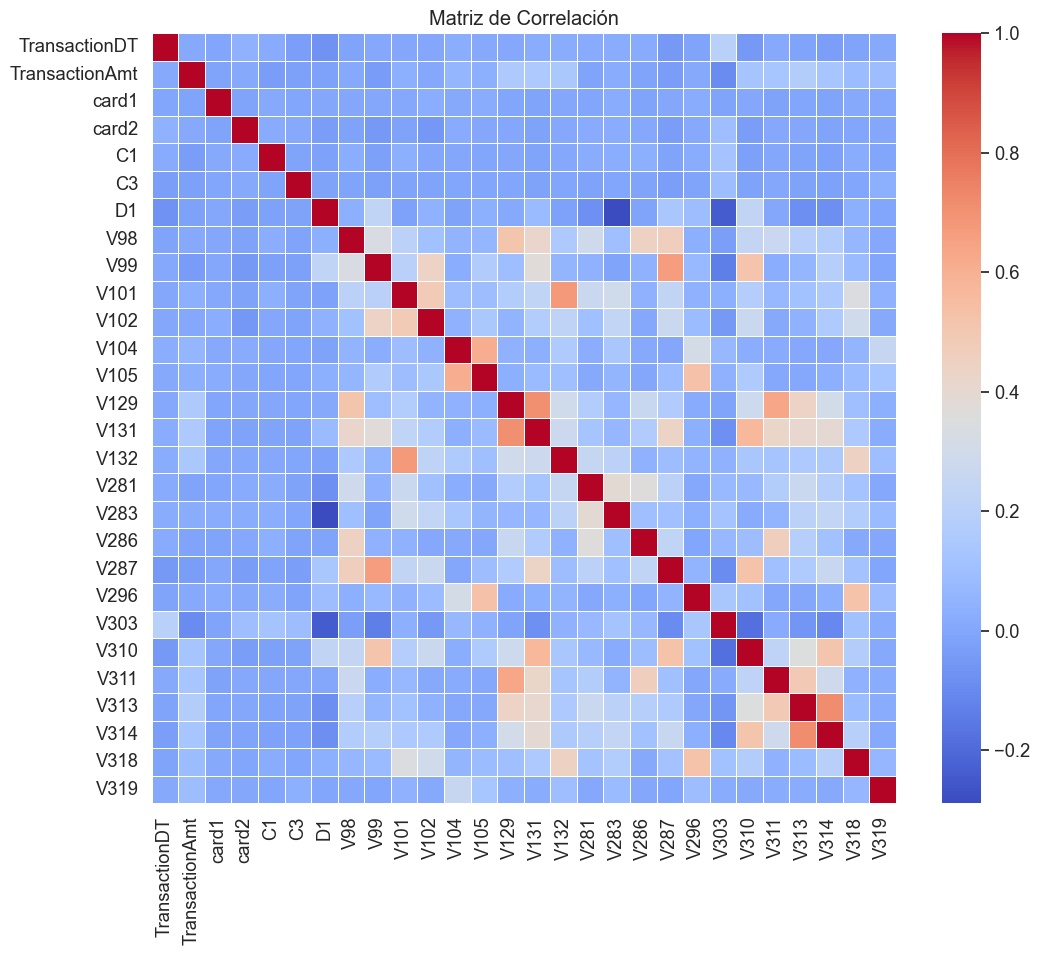

In [122]:
# Calcula la matriz de correlación
correlation_matrix = X_fraud_num.corr()

# Visualizar la matriz de correlación
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

* Se codifican las variables categóricas utilizando OneHotEncoder 

In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Inicializar el codificador OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' elimina una columna por categoría

# Ajustar y transformar el DataFrame
encoded_data = encoder.fit_transform(X_fraud_cat)

# Crear un nuevo DataFrame con las columnas codificadas
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(X_fraud_cat.columns))

# Imprimir el DataFrame resultante
print("DataFrame con codificación one-hot:")
print(encoded_df)


DataFrame con codificación one-hot:
       ProductCD_H  ProductCD_R  ProductCD_S  ProductCD_W
0              0.0          0.0          0.0          1.0
1              0.0          0.0          0.0          1.0
2              0.0          0.0          0.0          1.0
3              0.0          0.0          0.0          1.0
4              1.0          0.0          0.0          0.0
...            ...          ...          ...          ...
99994          0.0          0.0          0.0          1.0
99995          0.0          0.0          0.0          0.0
99996          0.0          0.0          0.0          1.0
99997          0.0          0.0          1.0          0.0
99998          1.0          0.0          0.0          0.0

[99999 rows x 4 columns]


#### EDA FRAUDE CON DATOS REDUCIDOS

In [124]:
# Datos que contienen todos los datos
data_fraud = pd.concat([y_fraud, X_fraud_num, encoded_df], axis=1)

# dataframe que contiene solo las variables predictoras.
X_fraud = pd.concat([X_fraud_num, encoded_df], axis=1)



* Se hace una muestra de las primeros 5 columnas para ver los datos, encontramos variables numericas y dummy.

In [125]:
data_fraud.head()

isFraud  TransactionDT  TransactionAmt    card1  card2   C1   C3     D1  \
0        0        86400.0            68.5  13926.0  387.0  1.0  0.0   14.0   
1        0        86401.0            29.0   2755.0  404.0  1.0  0.0    0.0   
2        0        86469.0            59.0   4663.0  490.0  1.0  0.0    0.0   
3        0        86499.0            50.0  18132.0  567.0  2.0  0.0  112.0   
4        0        86506.0            50.0   4497.0  514.0  1.0  0.0    0.0   

   V98   V99  ...   V310  V311  V313  V314   V318  V319  ProductCD_H  \
0  0.0   0.0  ...    0.0   0.0   0.0   0.0    0.0   0.0          0.0   
1  0.0   0.0  ...    0.0   0.0   0.0   0.0    0.0   0.0          0.0   
2  0.0   0.0  ...    0.0   0.0   0.0   0.0    0.0   0.0          0.0   
3  0.0  10.0  ...  354.0   0.0   0.0   0.0  790.0   0.0          0.0   
4  0.0   0.0  ...    0.0   0.0   0.0   0.0    0.0   0.0          1.0   

   ProductCD_R  ProductCD_S  ProductCD_W  
0          0.0          0.0          1.0  
1          0.0          0.0          1.0  
2          0.0          0.0          1.0  
3          0.0          0.0          1.0  
4          0.0          0.0          0.0  

[5 rows x 33 columns]

* Se muestra la información de las columnas del dataset, vemos que hay 32, de las cuales la primera es la variable a predecir, contiene 100.000 valores para cada columna.

In [126]:
# Ver información sobre las columnas y tipos de variables
data_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isFraud         99999 non-null  int8   
 1   TransactionDT   99999 non-null  float64
 2   TransactionAmt  99999 non-null  float64
 3   card1           99999 non-null  float64
 4   card2           99999 non-null  float64
 5   C1              99999 non-null  float64
 6   C3              99999 non-null  float64
 7   D1              99999 non-null  float64
 8   V98             99999 non-null  float64
 9   V99             99999 non-null  float64
 10  V101            99999 non-null  float64
 11  V102            99999 non-null  float64
 12  V104            99999 non-null  float64
 13  V105            99999 non-null  float64
 14  V129            99999 non-null  float64
 15  V131            99999 non-null  float64
 16  V132            99999 non-null  float64
 17  V281            99999 non-null 

* Aqui se describe el dataset, se observa que la variable a predecir tiene una media 0.025, es decir que estamos con una serie bastante desbalanceada lo cual complica la tarea de clasificación. Se podria explorar utilizando tecnicas de oversampling, sin embargo debido a motivos computacionales se dejara de esta forma. Otra tecnica posible seria realizar un subsampling, eliminado la clase mas común, sin embargo se puede perder información util.

In [127]:
data_fraud.describe()

isFraud  TransactionDT  TransactionAmt         card1         card2  \
count  99999.00000   9.999900e+04    99999.000000  99999.000000  99999.000000   
mean       0.02561   1.135115e+06      130.743836   9878.453325    371.106131   
std        0.15797   5.733446e+05      206.022020   4933.557719    158.173664   
min        0.00000   8.640000e+04        0.291992   1001.000000    100.000000   
25%        0.00000   6.537475e+05       45.000000   6019.000000    219.000000   
50%        0.00000   1.189336e+06       75.000000   9653.000000    387.000000   
75%        0.00000   1.643436e+06      136.000000  14290.000000    514.000000   
max        1.00000   2.006177e+06     4828.000000  18395.000000    600.000000   

                 C1            C3            D1           V98           V99  \
count  99999.000000  99999.000000  99999.000000  99999.000000  99999.000000   
mean      40.122851      0.012320     73.678377      0.053811      0.597436   
std      307.771602      0.133299    136.296198      0.252063      1.848045   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      0.000000   
75%        2.000000      0.000000     77.000000      0.000000      0.000000   
max     4684.000000     16.000000    639.000000      5.000000     46.000000   

       ...          V310          V311          V313          V314  \
count  ...  99999.000000  99999.000000  99999.000000  99999.000000   
mean   ...     83.589914      4.324368     16.181466     32.438549   
std    ...    250.958675     54.204366     82.665615    146.727455   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...     57.937500      0.000000      0.000000      0.000000   
max    ...  19808.000000   3162.000000   3956.000000   5020.000000   

               V318           V319   ProductCD_H   ProductCD_R   ProductCD_S  \
count  99999.000000   99999.000000  99999.000000  99999.000000  99999.000000   
mean      53.293155      16.422558      0.155212      0.137241      0.025260   
std      549.314610     402.826559      0.362108      0.344104      0.156915   
min        0.000000       0.000000      0.000000      0.000000      0.000000   
25%        0.000000       0.000000      0.000000      0.000000      0.000000   
50%        0.000000       0.000000      0.000000      0.000000      0.000000   
75%        0.000000       0.000000      0.000000      0.000000      0.000000   
max    26832.000000  101640.000000      1.000000      1.000000      1.000000   

        ProductCD_W  
count  99999.000000  
mean       0.568776  
std        0.495250  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000  

[8 rows x 33 columns]

* Se toman 5 variables de interes para confirmar su comportamiento y ver su relación con la variable independiente. En este caso: 'TransactionDT', 'TransactionAmt', 'card1', 'C1', 'D1'.

In [375]:
# Selección de las 4 variables de interés
variables_seleccionadas = ['isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'C1', 'D1']

# Crear un subconjunto de datos con las variables seleccionadas
subset_data = data_fraud[variables_seleccionadas]


##### Analisis Univariado.

Column:  isFraud
Skew: 6.01
Kurtosis:  34.07


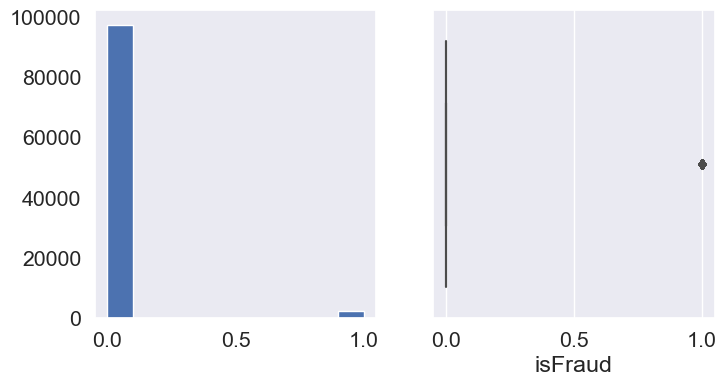

Column:  TransactionDT
Skew: -0.19
Kurtosis:  -1.22


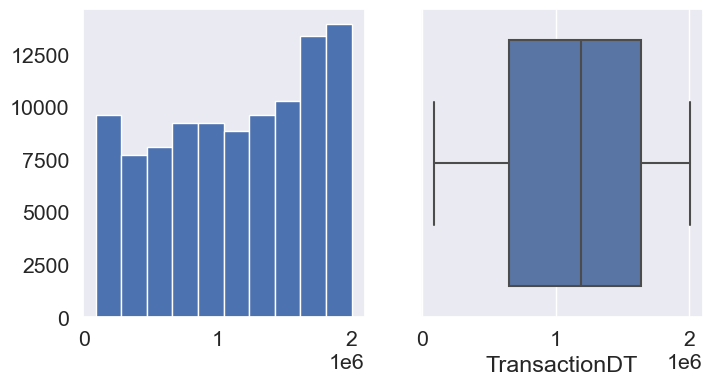

Column:  TransactionAmt
Skew: 6.78
Kurtosis:  70.15


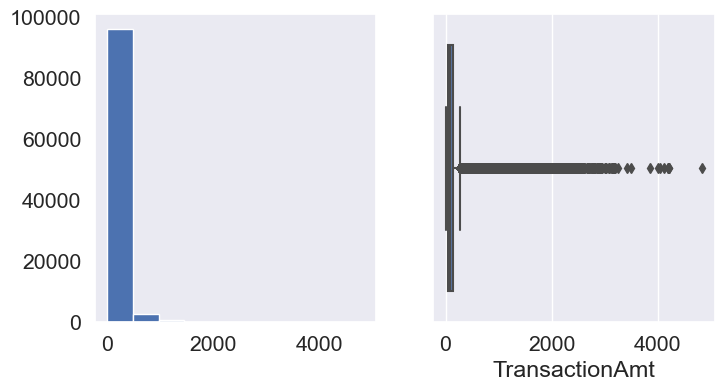

Column:  card1
Skew: -0.03
Kurtosis:  -1.15


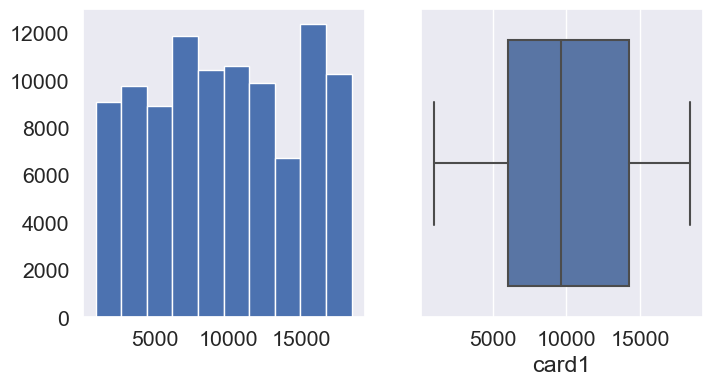

Column:  C1
Skew: 11.02
Kurtosis:  132.87


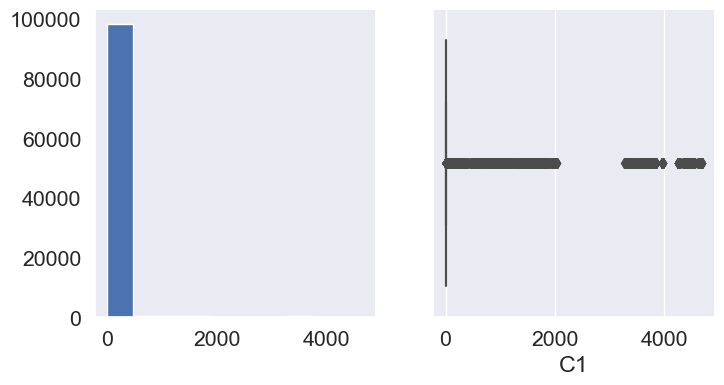

Column:  D1
Skew: 1.92
Kurtosis:  2.5


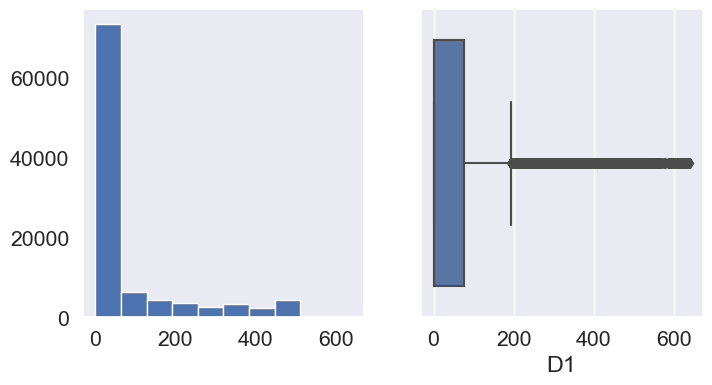

In [376]:
from scipy.stats import kurtosis

num_cols = subset_data.select_dtypes(include=np.number).columns.tolist()

sns.set(font_scale=1.4)
for col in num_cols:
    print('Column: ', col)
    print('Skew:', round(subset_data[col].skew(), 2))
    print('Kurtosis: ', round(subset_data[col].kurtosis(), 2))
    plt.figure(figsize = (8, 4))
    plt.subplot(1, 2, 1)
    subset_data[col].hist(grid=False)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=subset_data[col])
    plt.show()

* Se observa que la variable a predecir, si es fraude, se encuentra desbalanceada con muy pocos datos de fraude.
* Una distribución casi semetrica de TransactionDT que es el intervalo de tiempo, encontramos un sesgo hacia la izquierda con mayor frecuencia de valores a ser más altos.
* card1 que es información sobre la tarjeta, tiene un comportamiento similar a TransactionDT con un sesgo hacia la izquierda pero en menor proporción.
* TransactionAMT que es el Importe del pago, vemos que tiende a valores bajos con valores atípicos que corresponden a transacciones de grandes montos de dinero. 
* Vemos que la caracteristica C1, que corresponde a las direcciones asociadas se concentran en 0 y se encuentran bastantes outlayers a la derecha, unos clientes con muchas direcciones asociadas.
* D1 que corresponde con los días transcurridos entre la transacción anterior se concentran en valores bajos, con una cola larga y varios valores atipicos altos.

* De los graficos anteriores podemos ver que la clase a predecir "isFraud" se encuentra desbalanceada con muy pocos datos de fraude. Lo cual tiene sentido, ya que para operaciones bancarias que se presente fraude no es tan frecuente.

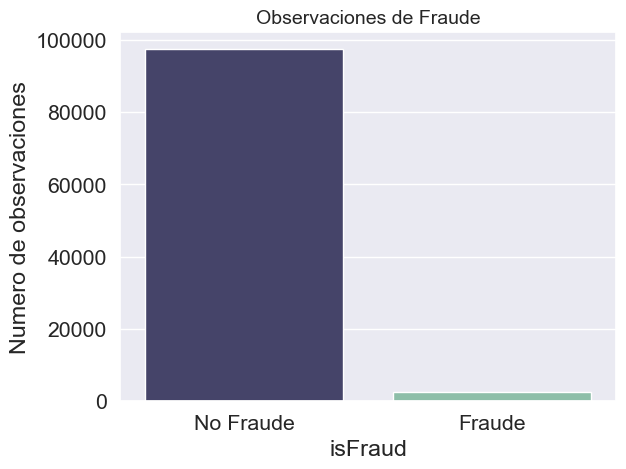

In [130]:

ax = sns.countplot(x = 'isFraud', data = subset_data, palette=["#3f3e6fd1", "#85c6a9"])
plt.xticks(np.arange(2), ['No Fraude', 'Fraude'])
plt.title('Observaciones de Fraude',fontsize= 14)
plt.ylabel('Numero de observaciones');



##### Analisis Bivariado

El análisis bivariado ayuda a comprender cómo se relacionan las variables entre sí y la relación entre las variables dependientes e independientes

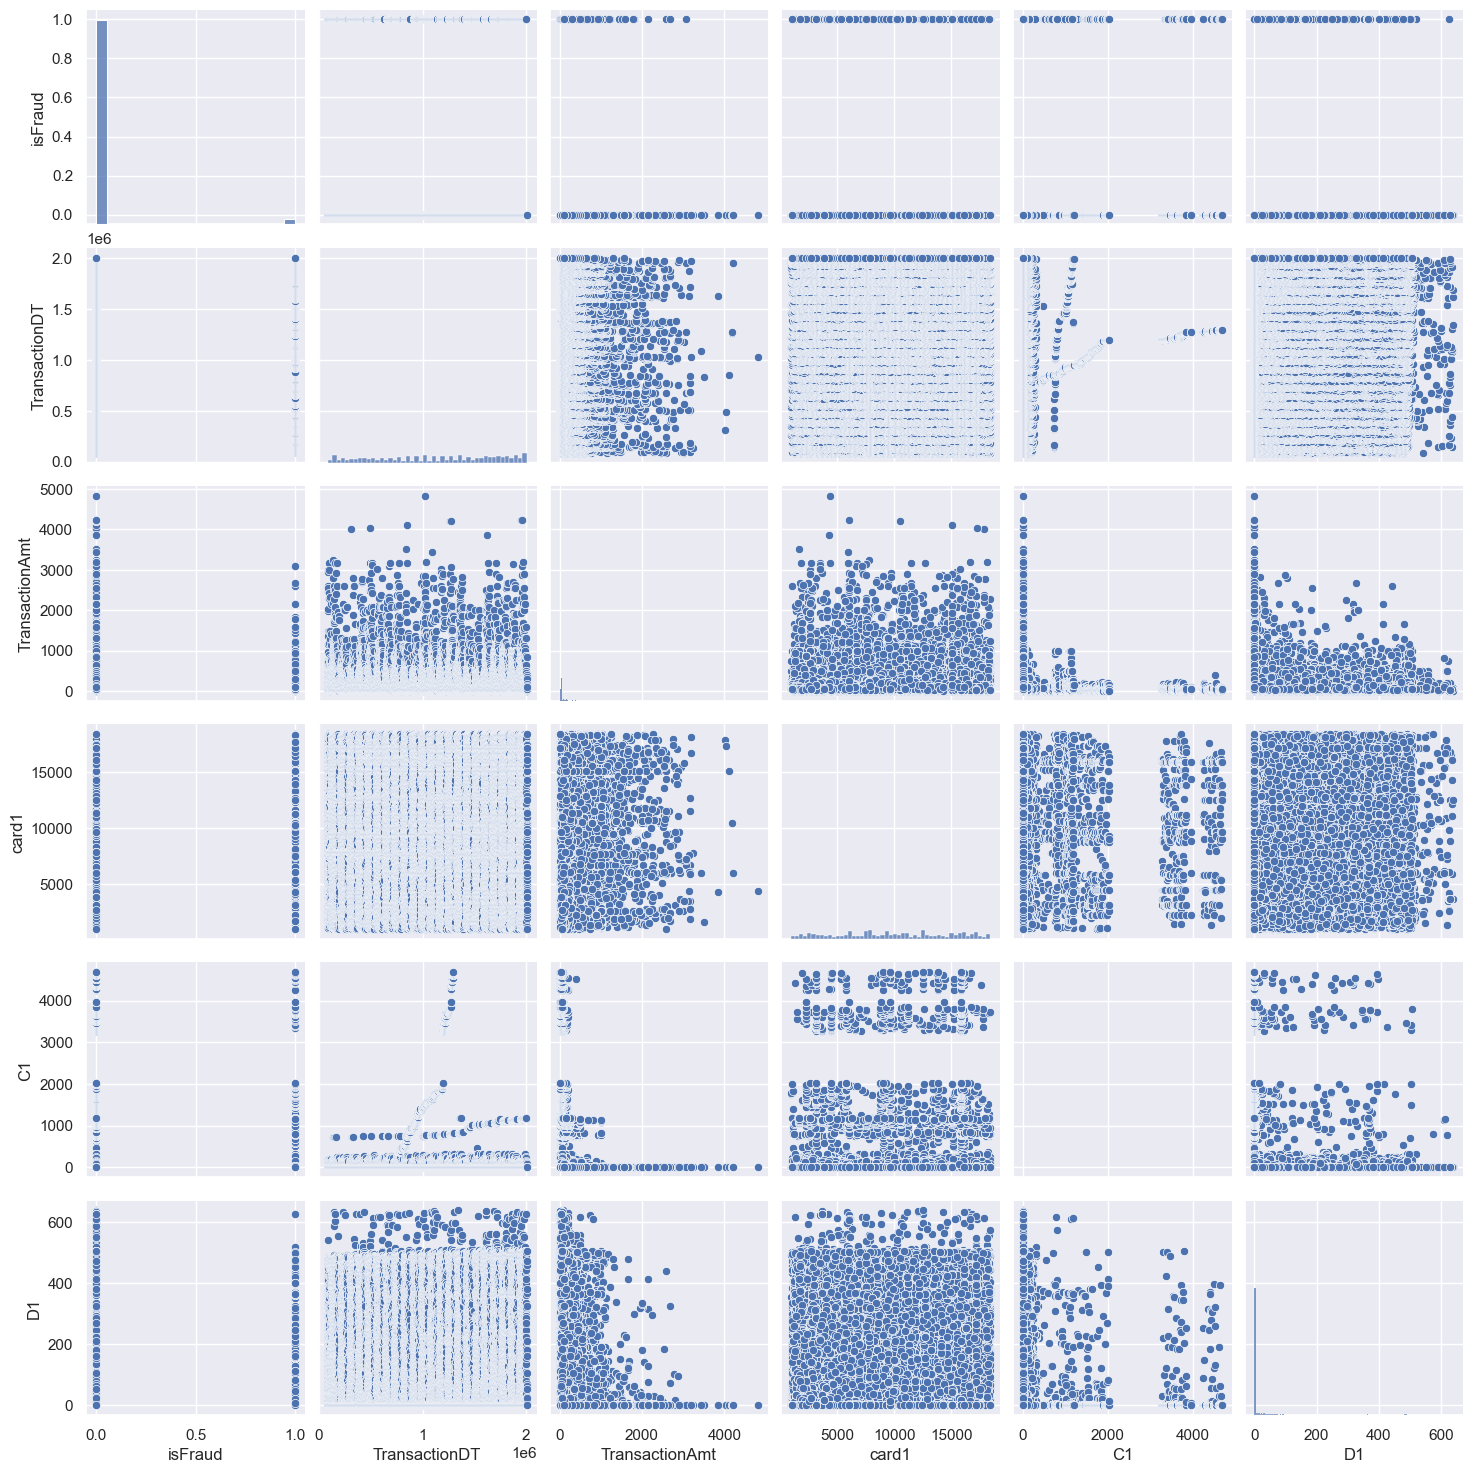

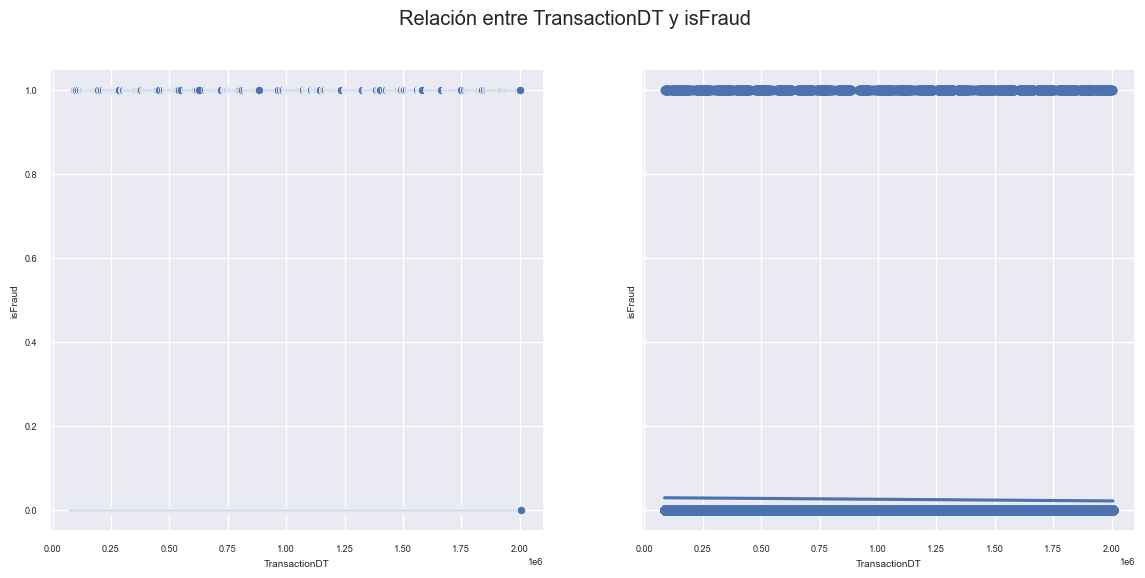

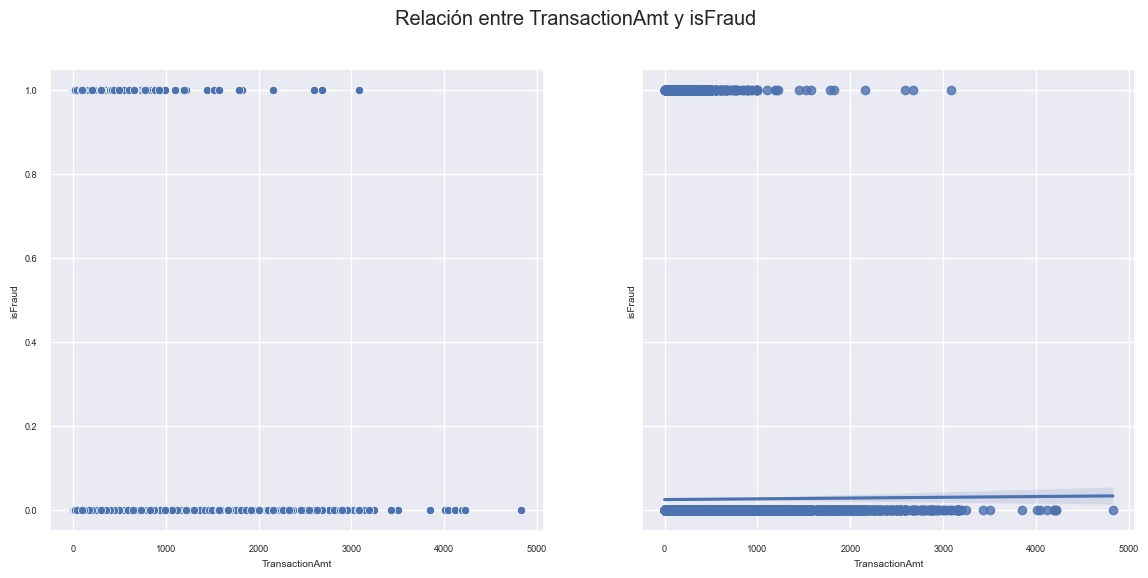

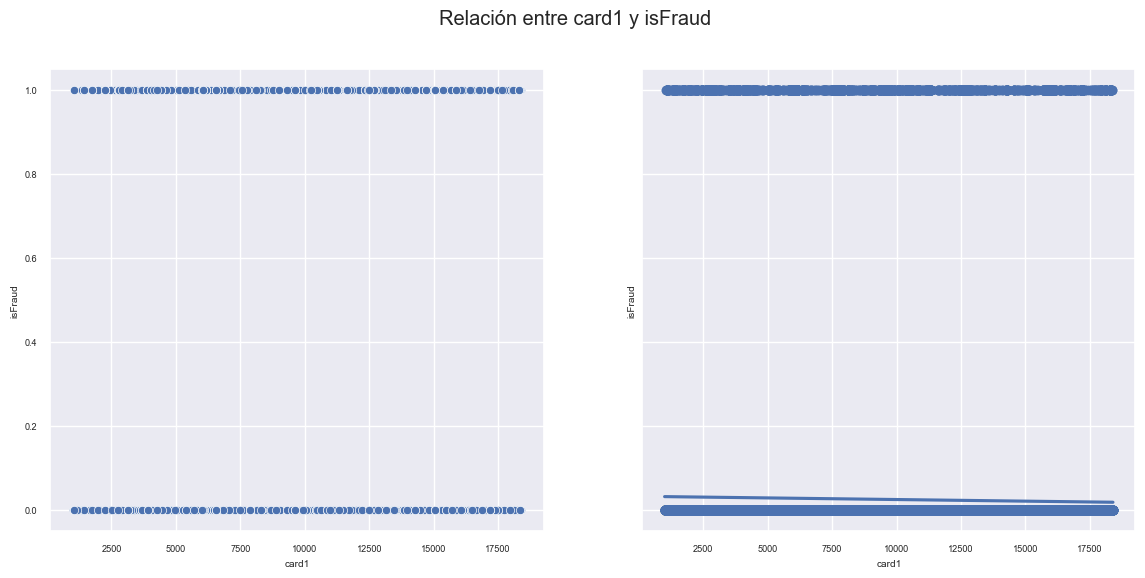

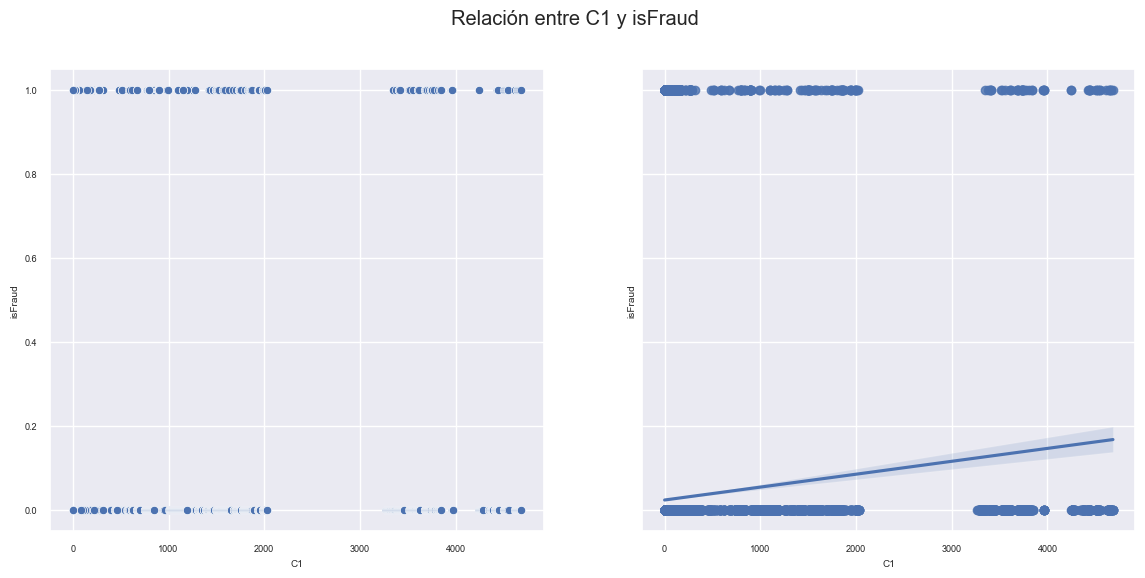

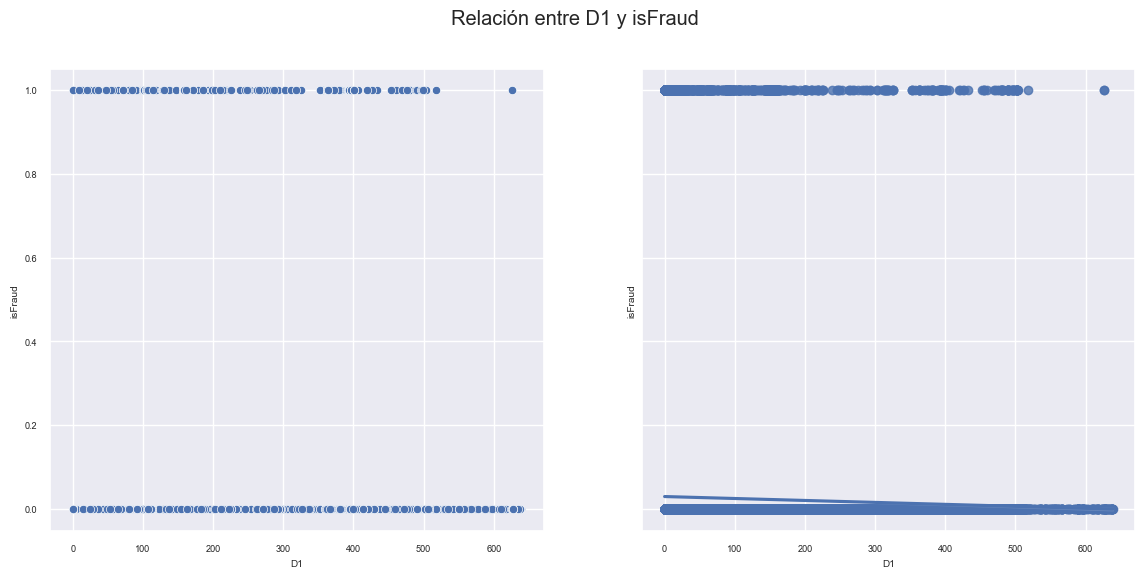

In [380]:
sns.pairplot(data=subset_data);

num_cols = subset_data.select_dtypes(include=np.number).columns.tolist()

def scatter_regplot(data, strx, stry):
    sns.set(font_scale=0.6)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.scatterplot(data=data, x=strx, y=stry, ax=ax[0])
    sns.set(font_scale=1)
    sns.regplot(data=data, x=strx, y=stry, ax=ax[1]);
    fig.suptitle('Relación entre %s y isFraud'%col)  

num_cols.remove('isFraud')
for col in num_cols:
    scatter_regplot(subset_data, col, 'isFraud')

* TransactionDT, card1, TransactionAMT no parecen tener una relación clara con la predicción de si es fraude, sin embargo se podria pensar que transacciones de mayor monto pueden corresponder a fraude.
* Tal como observamos en la parte de arriba C1 que corresponde al numero de direcciones asociadas, parece tener una correlaccion con la caracteristica a predecir de si es fraude, una cuenta con muchas cuentas asociadas puede ser victima de fraude.
* D1 que corresponde con los días transcurridos entre la transacción anterior, vemos que parece tener una correlación con el fraude, lo cual es probable si se hacen muchas transacciones seguidas puede corresponder con un caso de fraude.

### Wind Speed

In [323]:
wind_speed=pd.read_csv('data_treino_dv_df_2000_2010.csv')

En este Dataset se encuentran el siguiente tipo de Variables: 
* HORA (UTC): Hora
* VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr)): Dirección del viento horaria
* VENTO, VELOCIDADE HORARIA (m/s): Velocidad horario del viento (m/s)
* UMIDADE REL. MAX. NA HORA ANT. (AUT) ( %): Humedad rel. máx. hora anterior (AUT) ( %)
* UMIDADE REL. MIN. NA HORA ANT. (AUT) ( %): Humedad rel. mín. hora anterior (AUT) ( %) 
* TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C): Temperatura máx. hora anterior (AUT) (℃)
* TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C): Temperatura mín. hora anterior (AUT) ( ℃)
* UMIDADE RELATIVA DO AR, HORARIA ( %): Humedad relativa horaria ( %)
* PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB): Presión atmosférica a nivel de estación, horaria (mB)
* PRECIPITACION TOTAL, HORARIO (mm): Precipitación total por hora (mm)
* VENTO, RAJADA MAXIMA (m/s): Máxima ráfaga de viento (m/s)
* PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB): Presión atmosférica máx. hora anterior (AUT) (mB)
* PRESSï¿½O ATMOSFERICA MIN.NA HORA ANT. (AUT) (mB): Presión atmosférica mín. hora anterior (AUT) (mB)

In [324]:
wind_speed

HORA (UTC)  VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))  \
0          12:00                                    0.809017   
1          13:00                                    0.965926   
2          14:00                                    0.891007   
3          15:00                                    0.848048   
4          16:00                                    0.224951   
...          ...                                         ...   
87688      19:00                                   -0.615661   
87689      20:00                                   -0.469472   
87690      21:00                                   -0.484810   
87691      22:00                                   -0.484810   
87692      23:00                                   -0.573576   

       VENTO, VELOCIDADE HORARIA (m/s)  \
0                                  1.8   
1                                  2.7   
2                                  2.0   
3                                  2.5   
4                                  2.4   
...                                ...   
87688                              5.6   
87689                              4.9   
87690                              4.5   
87691                              3.2   
87692                              2.3   

       UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                                          69.0   
1                                          62.0   
2                                          56.0   
3                                          52.0   
4                                          50.0   
...                                         ...   
87688                                      83.0   
87689                                      84.0   
87690                                      86.0   
87691                                      88.0   
87692                                      95.0   

       UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                          60.0   
1                                          55.0   
2                                          50.0   
3                                          44.0   
4                                          43.0   
...                                         ...   
87688                                      78.0   
87689                                      79.0   
87690                                      82.0   
87691                                      85.0   
87692                                      88.0   

       TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                                22.6   
1                                                24.2   
2                                                25.5   
3                                                27.4   
4                                                27.1   
...                                               ...   
87688                                            21.8   
87689                                            21.7   
87690                                            21.2   
87691                                            20.6   
87692                                            20.2   

       TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                                20.7   
1                                                22.5   
2                                                24.3   
3                                                25.0   
4                                                25.5   
...                                               ...   
87688                                            21.1   
87689                                            21.0   
87690                                            20.6   
87691                                            20.2   
87692                                            19.3   

       UMIDADE RELATIVA DO AR, HORARIA (%)  \
0                                     61.0   
1                                     55.0  

Se establecen los nombres que se pondran a las columnas, que son los nombres originales pero reducidos en tamaño para su visualización.

In [325]:
nuevos_nombres = ['Hora', 'dir_viento', 'vel_viento', 'Humedad rel. máx','Humedad rel. mín.','Temp. máx','Temp mín.', 'Humedad rel horaria', 'Presión atm', 'Precip', 'Máx ráfaga', 'Presión atm máx', 'Presión atm mín']

In [326]:
wind_speed.columns = nuevos_nombres

* Se muestran los primeros 5 valores para ver una muestra de los datos.

In [327]:
wind_speed.head()

Hora  dir_viento  vel_viento  Humedad rel. máx  Humedad rel. mín.  \
0  12:00    0.809017         1.8              69.0               60.0   
1  13:00    0.965926         2.7              62.0               55.0   
2  14:00    0.891007         2.0              56.0               50.0   
3  15:00    0.848048         2.5              52.0               44.0   
4  16:00    0.224951         2.4              50.0               43.0   

   Temp. máx  Temp mín.  Humedad rel horaria  Presión atm  Precip  Máx ráfaga  \
0       22.6       20.7                 61.0        888.2     0.0         3.8   
1       24.2       22.5                 55.0        888.4     0.0         4.7   
2       25.5       24.3                 51.0        888.1     0.0         4.9   
3       27.4       25.0                 44.0        887.4     0.0         5.8   
4       27.1       25.5                 46.0        886.5     0.0         5.8   

   Presión atm máx  Presión atm mín  
0            888.2            887.7  
1            888.4            888.2  
2            888.4            888.1  
3            888.1            887.4  
4            887.4            886.5

Se reemplazara la columna de hora por un numero incremental de 0 al final de observaciones ya que es una serie continua.

In [290]:
"""# Definir una función para convertir el formato "HH:MM" a un valor numérico de velocidad del viento
def convert_to_wind_speed(time_str):
    parts = time_str.split(':')
    if len(parts) == 2:
        try:
            wind_speed = float(parts[0])
            return wind_speed
        except ValueError:
            pass
    return None

# Aplicar la función de conversión a la columna "wind_speed"
wind_speed['Hora'] = wind_speed['Hora'].apply(convert_to_wind_speed)

# Imprimir el DataFrame resultante
print(wind_speed)"""

       Hora  dir_viento  vel_viento  Humedad rel. máx  Humedad rel. mín.  \
0      12.0    0.809017         1.8              69.0               60.0   
1      13.0    0.965926         2.7              62.0               55.0   
2      14.0    0.891007         2.0              56.0               50.0   
3      15.0    0.848048         2.5              52.0               44.0   
4      16.0    0.224951         2.4              50.0               43.0   
...     ...         ...         ...               ...                ...   
87688  19.0   -0.615661         5.6              83.0               78.0   
87689  20.0   -0.469472         4.9              84.0               79.0   
87690  21.0   -0.484810         4.5              86.0               82.0   
87691  22.0   -0.484810         3.2              88.0               85.0   
87692  23.0   -0.573576         2.3              95.0               88.0   

       Temp. máx  Temp mín.  Humedad rel horaria  Presión atm  Precip  \
0           22

In [328]:
# Agregar una nueva columna 'NumeroIncremental' con valores incrementales
wind_speed['NumeroIncremental'] = range(1, len(wind_speed) + 1)

# Reemplazar la columna 'Hora' con 'NumeroIncremental'
wind_speed['Hora'] = wind_speed['NumeroIncremental']

# Eliminar la columna 'NumeroIncremental' si no la necesitas más
wind_speed.drop(columns=['NumeroIncremental'], inplace=True)

In [329]:
wind_speed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87693 entries, 0 to 87692
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Hora                 87693 non-null  int64  
 1   dir_viento           87693 non-null  float64
 2   vel_viento           87693 non-null  float64
 3   Humedad rel. máx     87693 non-null  float64
 4   Humedad rel. mín.    87693 non-null  float64
 5   Temp. máx            87693 non-null  float64
 6   Temp mín.            87693 non-null  float64
 7   Humedad rel horaria  87693 non-null  float64
 8   Presión atm          87693 non-null  float64
 9   Precip               87693 non-null  float64
 10  Máx ráfaga           87693 non-null  float64
 11  Presión atm máx      87693 non-null  float64
 12  Presión atm mín      87693 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 8.7 MB


* Se muestra la descripción de las columnas. Vemos que tenemos 87692 observaciones de velocidad de viento. 

In [330]:
wind_speed.describe()

Hora    dir_viento    vel_viento  Humedad rel. máx  \
count  87693.000000  87693.000000  87693.000000      87693.000000   
mean   43847.000000      0.405810      2.466192         69.058465   
std    25314.932915      0.686247      1.313968         19.640222   
min        1.000000     -1.000000      0.000000         12.000000   
25%    21924.000000     -0.156434      1.500000         54.000000   
50%    43847.000000      0.788011      2.400000         72.000000   
75%    65770.000000      0.970296      3.400000         87.000000   
max    87693.000000      1.000000     10.000000        100.000000   

       Humedad rel. mín.     Temp. máx     Temp mín.  Humedad rel horaria  \
count       87693.000000  87693.000000  87693.000000         87693.000000   
mean           63.176194     21.921264     20.684570            66.146682   
std            20.166336      3.721386      3.513744            19.992327   
min            10.000000      9.200000      8.400000            10.000000   
25%            48.000000     19.200000     18.400000            51.000000   
50%            64.000000     21.400000     20.200000            68.000000   
75%            80.000000     24.700000     23.100000            84.000000   
max            98.000000     35.300000     34.400000            99.000000   

        Presión atm        Precip    Máx ráfaga  Presión atm máx  \
count  87693.000000  87693.000000  87693.000000     87693.000000   
mean     887.251925      0.160907      5.161076       887.580724   
std        4.012404      1.307515      2.311157         3.646750   
min      863.400000      0.000000      0.000000       865.300000   
25%      885.300000      0.000000      3.400000       885.600000   
50%      887.200000      0.000000      5.000000       887.500000   
75%      889.100000      0.000000      6.800000       889.300000   
max     1023.500000     70.800000     24.300000       913.100000   

       Presión atm mín  
count     87693.000000  
mean        886.891093  
std           3.564539  
min         862.800000  
25%         885.000000  
50%         886.900000  
75%         888.800000  
max         910.900000

* Vemos que no encuentra ningun valor nulo en la serie, no es necesario realizar imputación de datos.

In [331]:
wind_speed.isnull().sum()

Hora                   0
dir_viento             0
vel_viento             0
Humedad rel. máx       0
Humedad rel. mín.      0
Temp. máx              0
Temp mín.              0
Humedad rel horaria    0
Presión atm            0
Precip                 0
Máx ráfaga             0
Presión atm máx        0
Presión atm mín        0
dtype: int64

In [332]:
porcentaje_nulos = (wind_speed.isnull().sum() / len(wind_speed)) * 100

# 'porcentaje_nulos' ahora contiene el porcentaje de valores nulos para cada columna
print(f'Porcentaje de valores nulos')

print(porcentaje_nulos)

print('')
print(f'Numero de datos faltantes')
print(wind_speed.isnull().sum())

Porcentaje de valores nulos
Hora                   0.0
dir_viento             0.0
vel_viento             0.0
Humedad rel. máx       0.0
Humedad rel. mín.      0.0
Temp. máx              0.0
Temp mín.              0.0
Humedad rel horaria    0.0
Presión atm            0.0
Precip                 0.0
Máx ráfaga             0.0
Presión atm máx        0.0
Presión atm mín        0.0
dtype: float64

Numero de datos faltantes
Hora                   0
dir_viento             0
vel_viento             0
Humedad rel. máx       0
Humedad rel. mín.      0
Temp. máx              0
Temp mín.              0
Humedad rel horaria    0
Presión atm            0
Precip                 0
Máx ráfaga             0
Presión atm máx        0
Presión atm mín        0
dtype: int64


Como se observa no se encuentra ningun valor nulo en el dataset.

#### Analisis Univariado

Column:  Hora
Skew: 0.0
Kurtosis:  -1.2


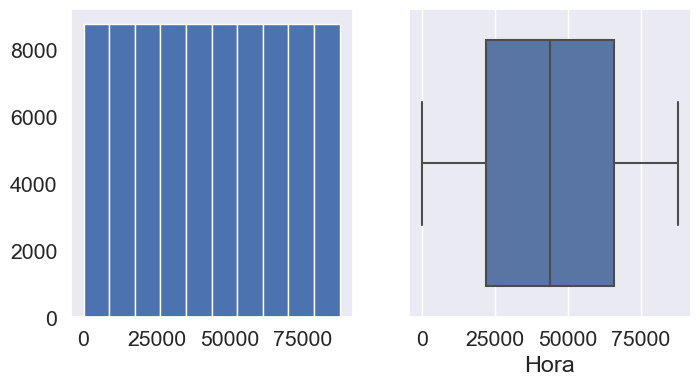

Column:  dir_viento
Skew: -0.86
Kurtosis:  -0.82


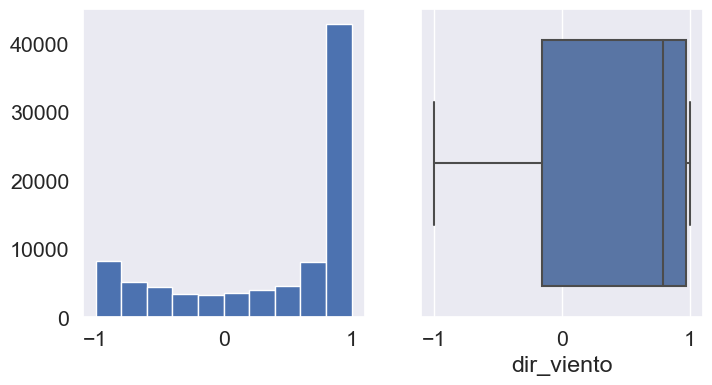

Column:  vel_viento
Skew: 0.37
Kurtosis:  -0.11


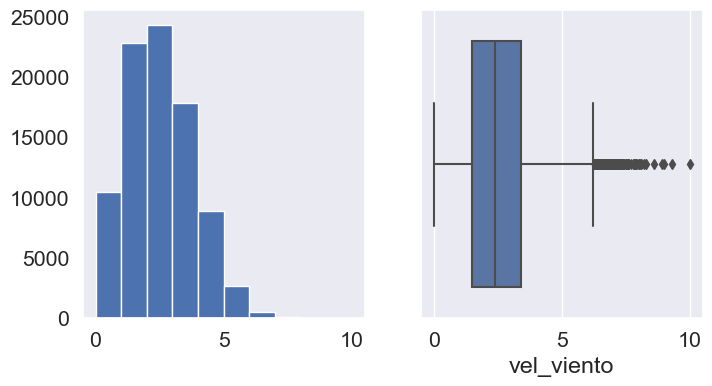

Column:  Humedad rel. máx
Skew: -0.48
Kurtosis:  -0.78


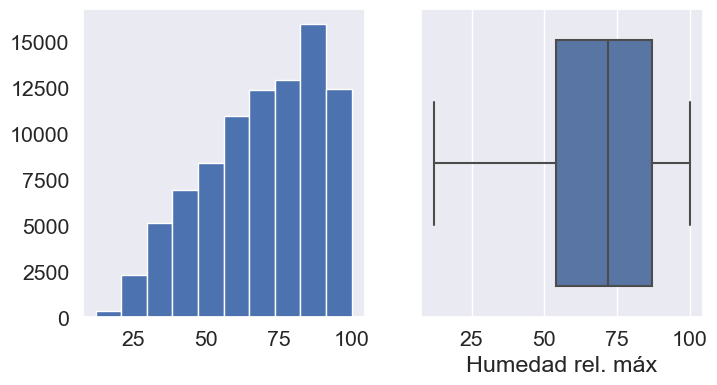

Column:  Humedad rel. mín.
Skew: -0.23
Kurtosis:  -0.96


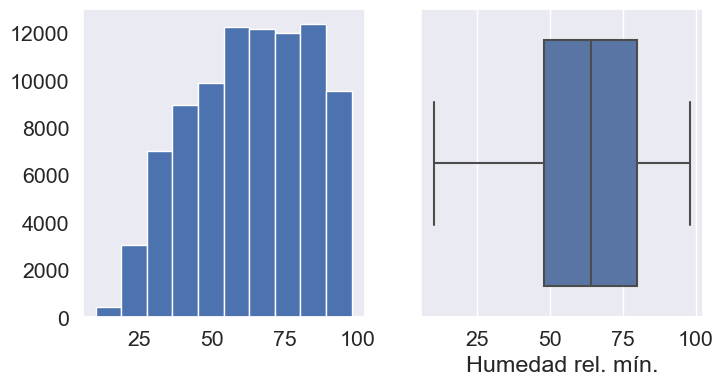

Column:  Temp. máx
Skew: 0.26
Kurtosis:  -0.42


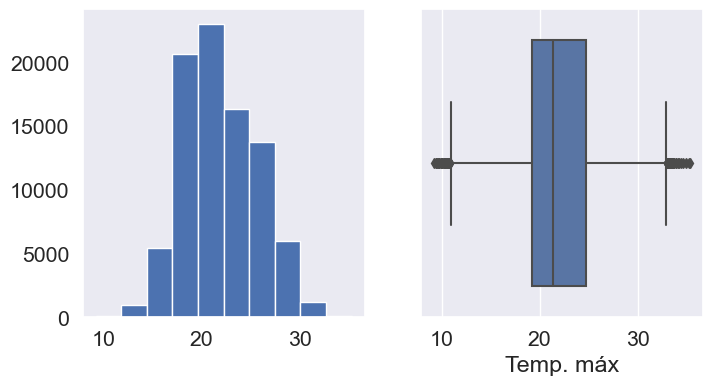

Column:  Temp mín.
Skew: 0.24
Kurtosis:  -0.12


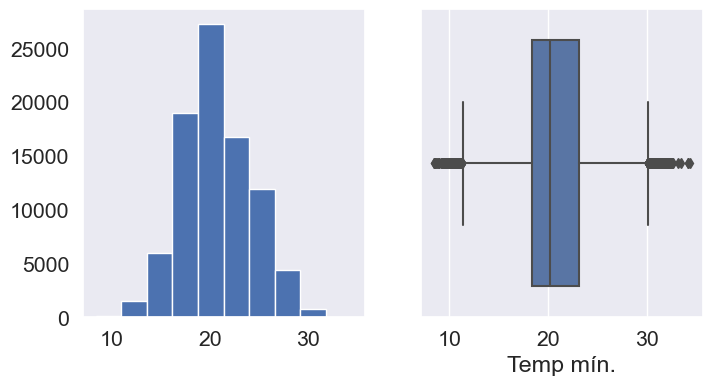

Column:  Humedad rel horaria
Skew: -0.35
Kurtosis:  -0.89


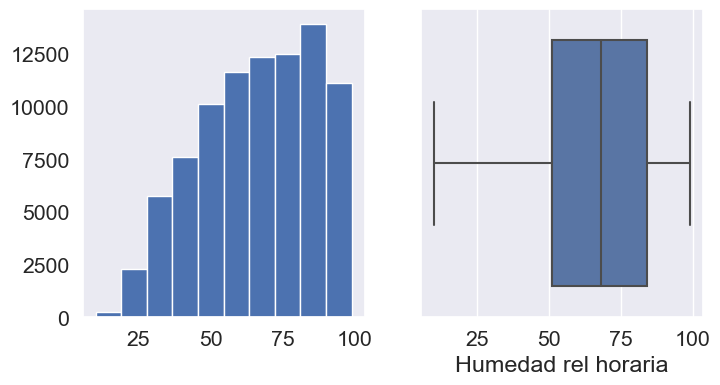

Column:  Presión atm
Skew: 6.18
Kurtosis:  179.64


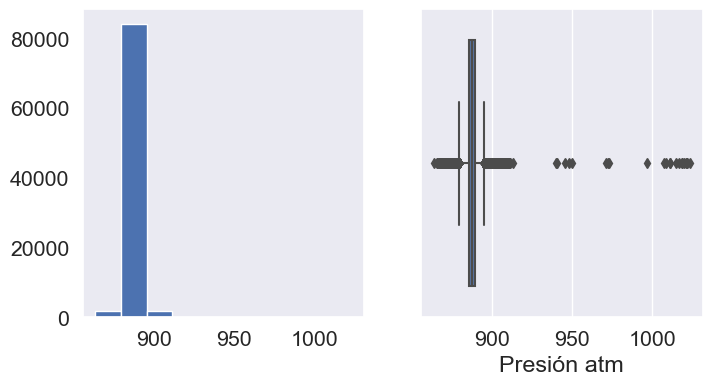

Column:  Precip
Skew: 17.65
Kurtosis:  476.4


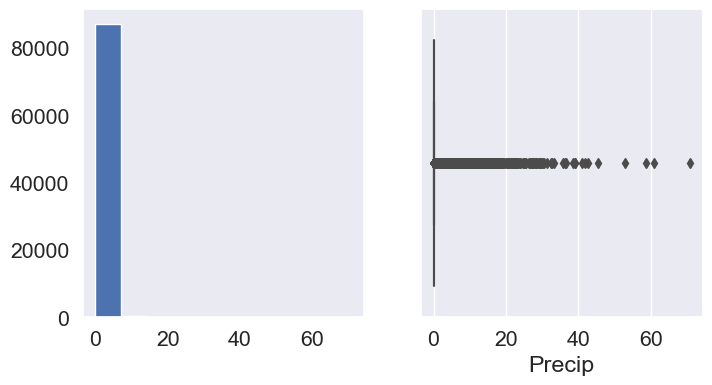

Column:  Máx ráfaga
Skew: 0.41
Kurtosis:  0.11


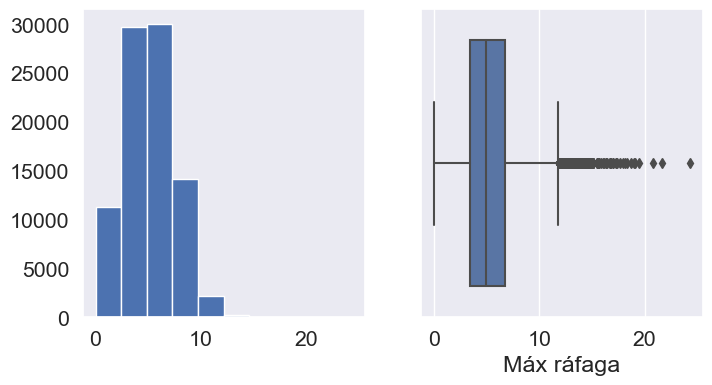

Column:  Presión atm máx
Skew: 1.02
Kurtosis:  5.82


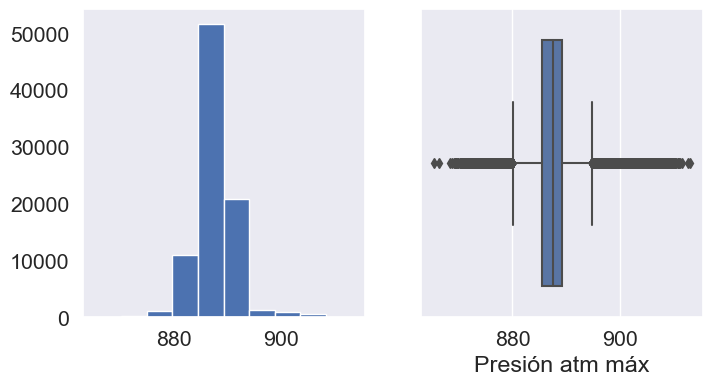

Column:  Presión atm mín
Skew: 0.33
Kurtosis:  4.91


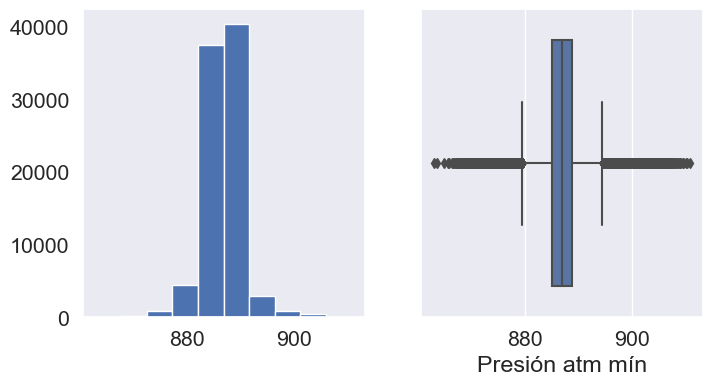

In [333]:
from scipy.stats import kurtosis
num_cols = wind_speed.select_dtypes(include=np.number).columns.tolist()

sns.set(font_scale=1.4)
for col in num_cols:
    print('Column: ', col)
    print('Skew:', round(wind_speed[col].skew(), 2))
    print('Kurtosis: ', round(wind_speed[col].kurtosis(), 2))
    plt.figure(figsize = (8, 4))
    plt.subplot(1, 2, 1)
    wind_speed[col].hist(grid=False)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=wind_speed[col])
    plt.show()

* La Hora que es una variable continua tal como se espera tiene una distribución uniforme.
* Se observa que la  dirección del viento tiene un sesgo hacia la derecha, es decir que el viento en la gran parte del año viene de una dirreción predeterminada.
* Mientras que la velocidad del viento, la variable a predecir tiene un sesgo hacia la izquierda, con varios outlayer en el margen superior. Al igual que la varible rafaga de viento. Es decir que es mas común encontrar bajas velocidades de viento.
* Tanto la presion atmosferica maxima como minima tienen una distribucion casi simetrica, con valores atipicos en ambas colas.
* En la precipitacion nos encontramos con muchos outlayer, es normal que no lluevan todas las horas del año, si no que corresponde a eventos no muy comunes y sobretodo no durante muchas horas.

#### Analisis Bivariado.

* En el siguiente grafico podemos observar que hay variables con una gran correlación entre ellas las que aportan la misma información como son las humedades y las presiones.

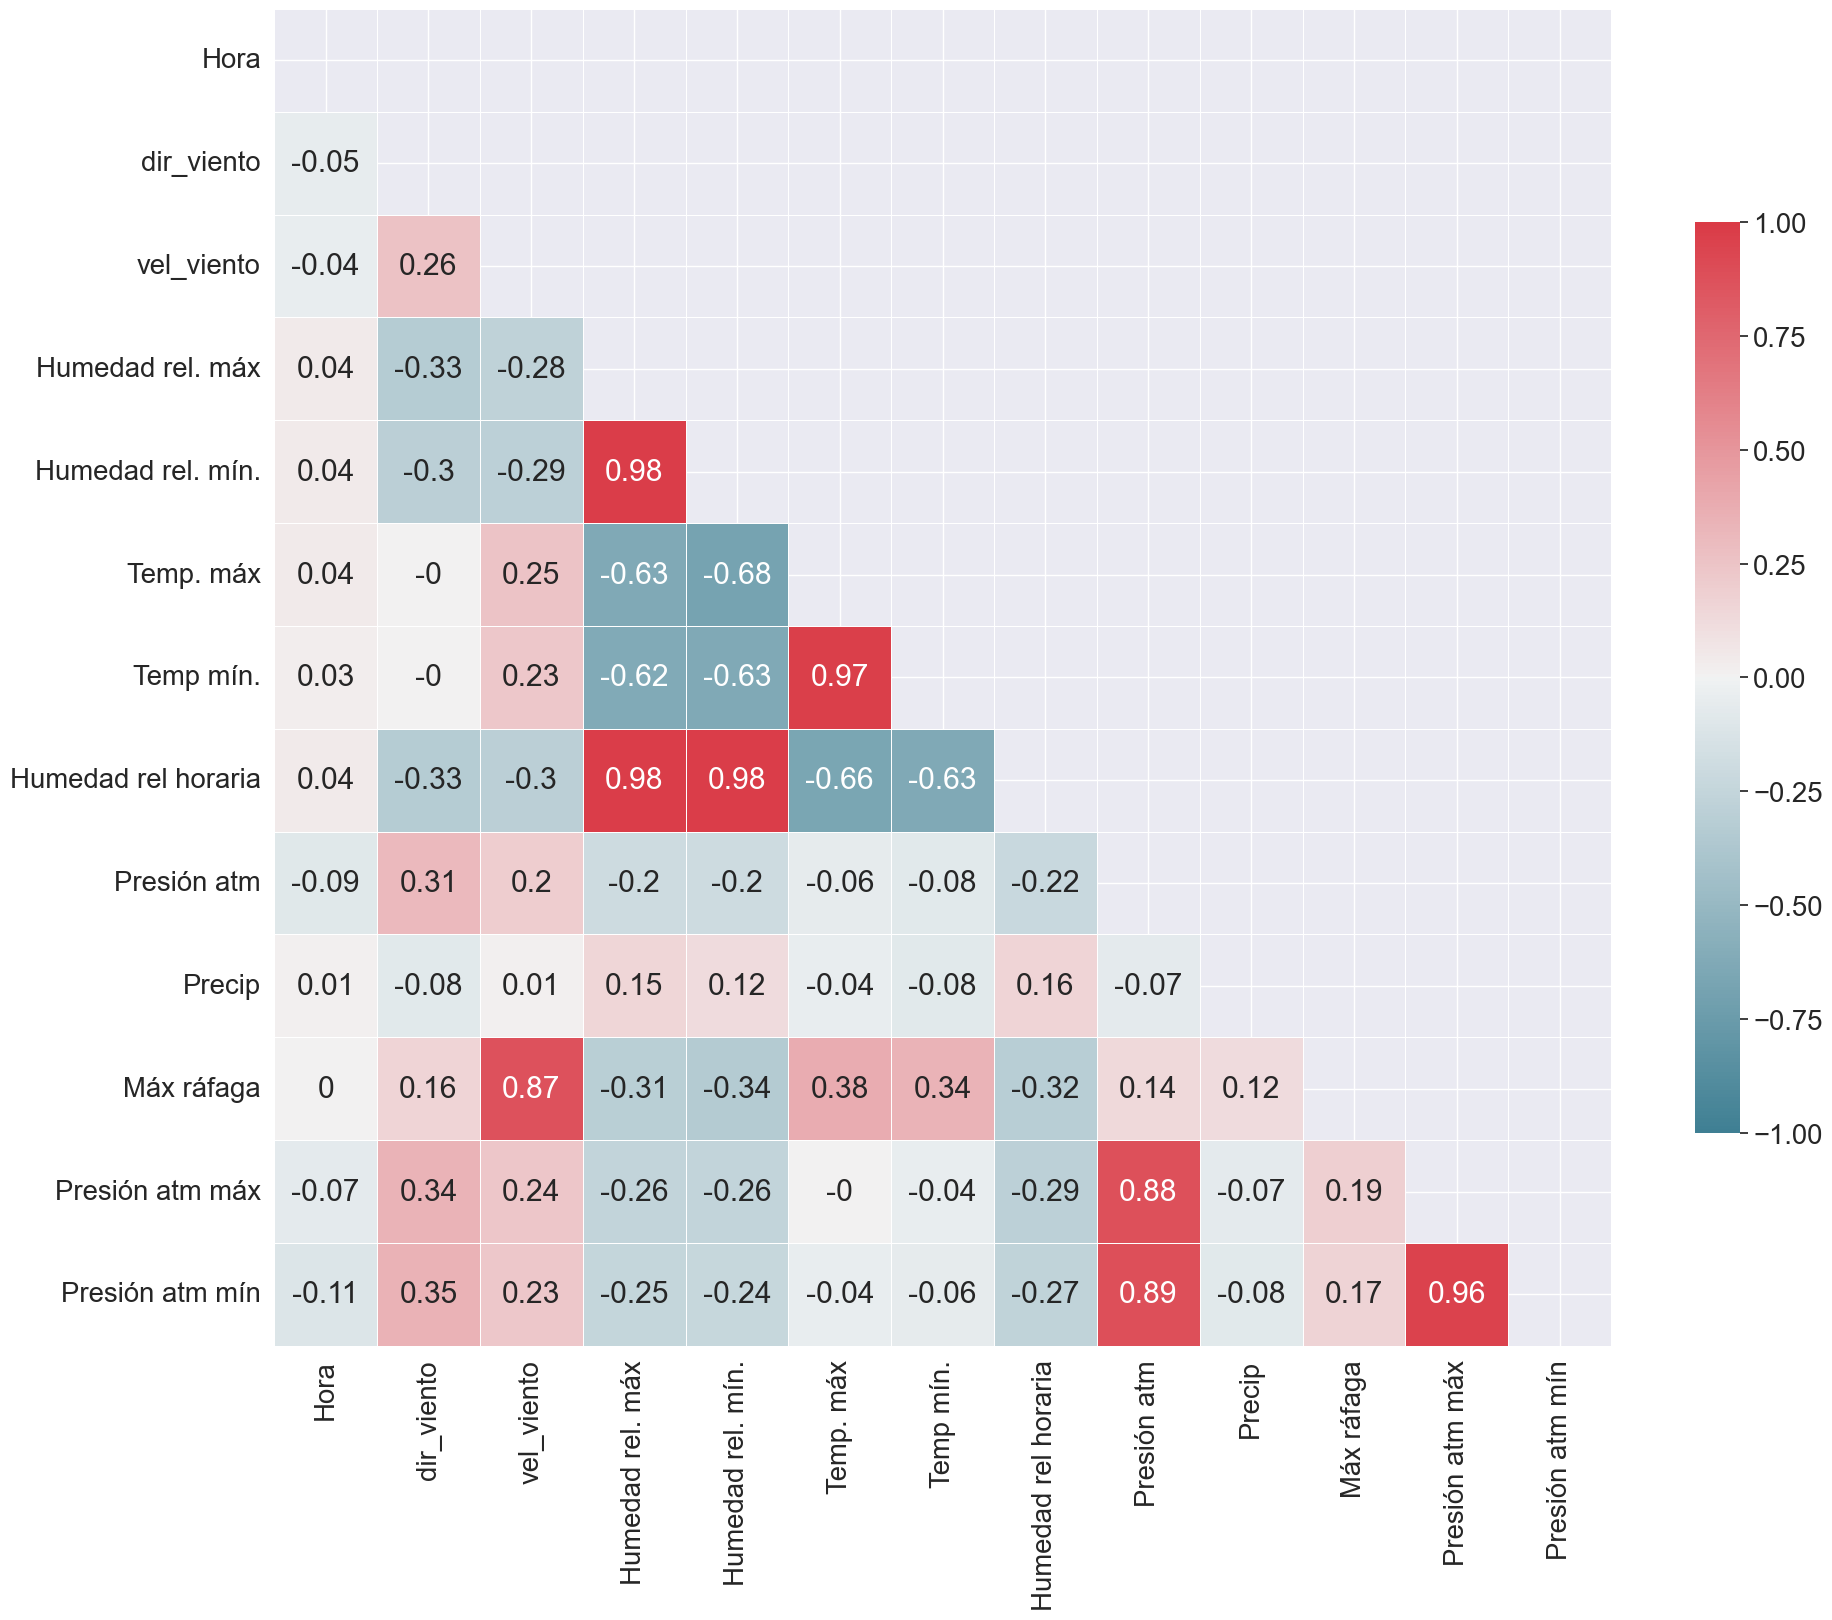

In [334]:
corr = wind_speed.corr().round(2)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.8)
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5,
            cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()
    

In [335]:

X_wind = wind_speed.drop(columns='vel_viento') # Se elimina la variable objetivo

columnas = X_wind.columns


* Se aplica la funcion VIF para eliminar las variables independientes que tienen un numero mayor a 5, para mejorar el modelo y evitar multicolinealidad.

In [336]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif_c(X, columnas):
    vif1 = pd.DataFrame()
    vif1["Variable"] = columnas
    vif1["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif1

while True:
    vif1 = vif_c(X_wind, columnas)
    indice_max_vif = vif1['VIF'].idxmax()
    
    if vif1['VIF'].max() < 5:
        break
    
    # Elimina la columna con el VIF máximo en X_wind
    X_wind = X_wind.drop(columns=columnas[indice_max_vif])
    
    # Actualiza la lista de columnas
    columnas = X_wind.columns.tolist()


* Se observa que las variables independientes restantes tienen un VIF MENOR A 5.

In [337]:
vif1

Variable       VIF
0               Hora  3.642612
1         dir_viento  1.391810
2  Humedad rel. mín.  4.335392
3             Precip  1.041362
4         Máx ráfaga  4.045390

In [338]:
wind_merge = X_wind.merge(wind_speed[['vel_viento']].copy(), left_index=True, right_index=True)


* Efectivamente podemos observar que las variables independientes no se encuentran correlacionadas y tenemos un modelo mas sencillo.

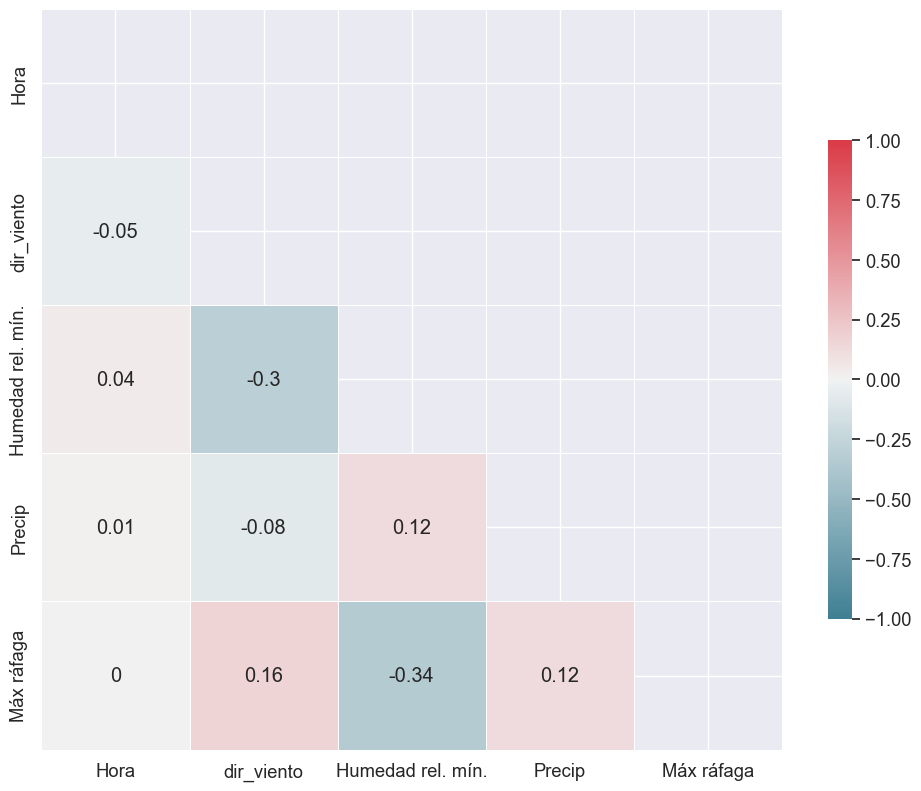

In [339]:
corr = X_wind.corr().round(2)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.2)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5,
            cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

* Se reliza un  scatterplot() y regplot(), para evaluar la relación de las variable a predecir "vel_viento" con las variables independientes que sobrevivieron al filtro de VIF, y entre todas las variables.

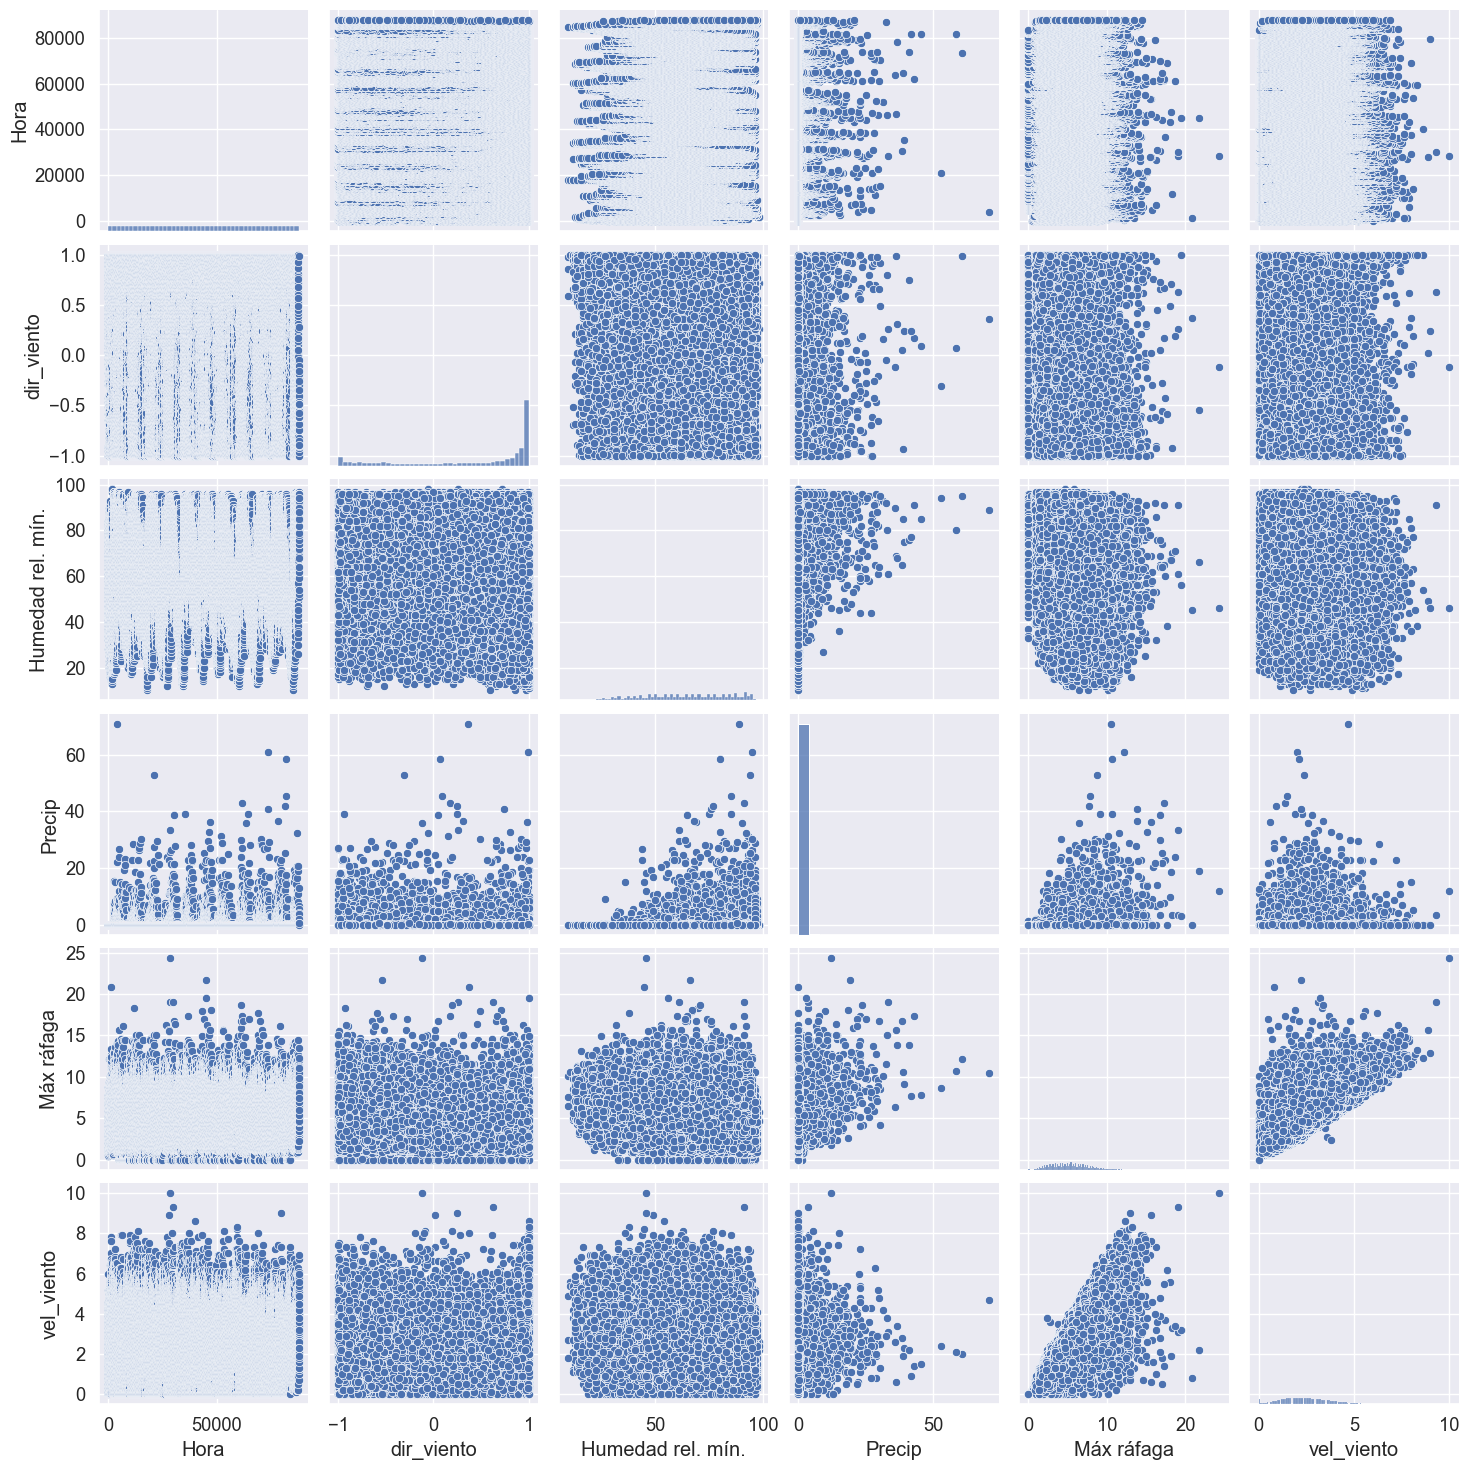

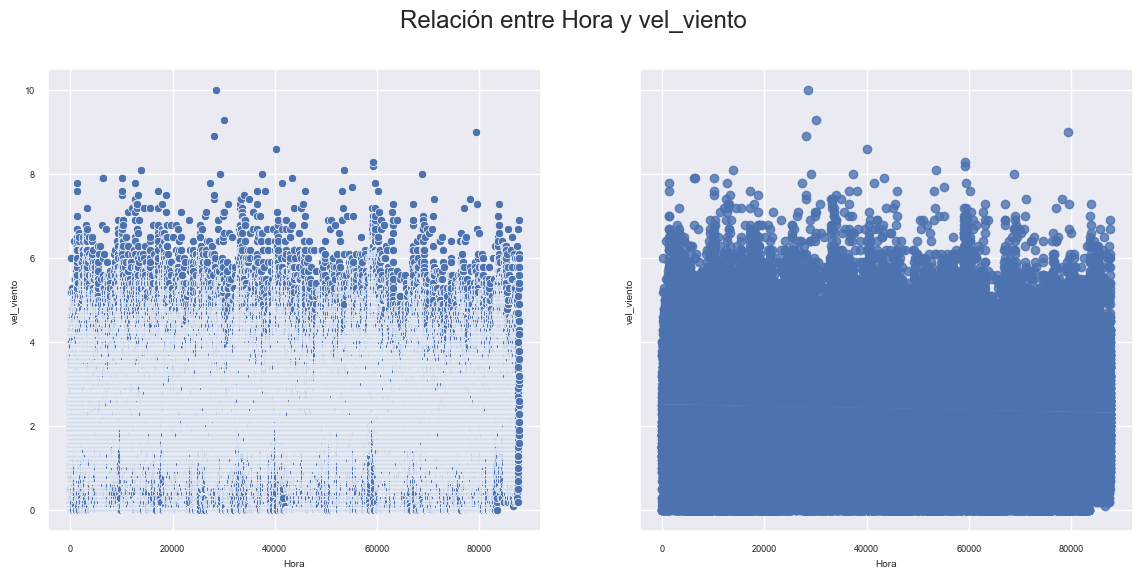

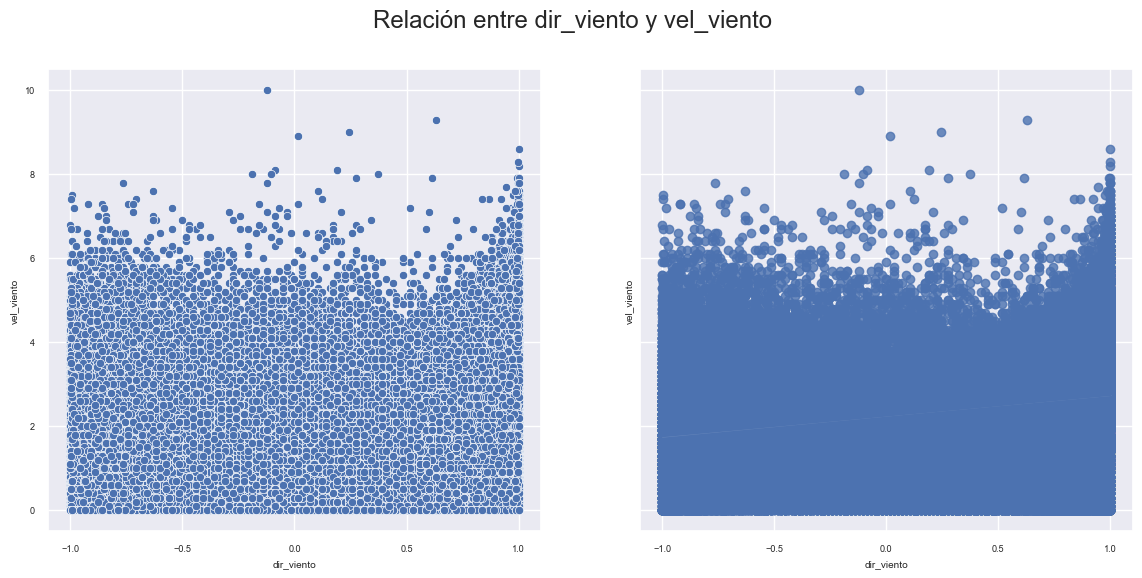

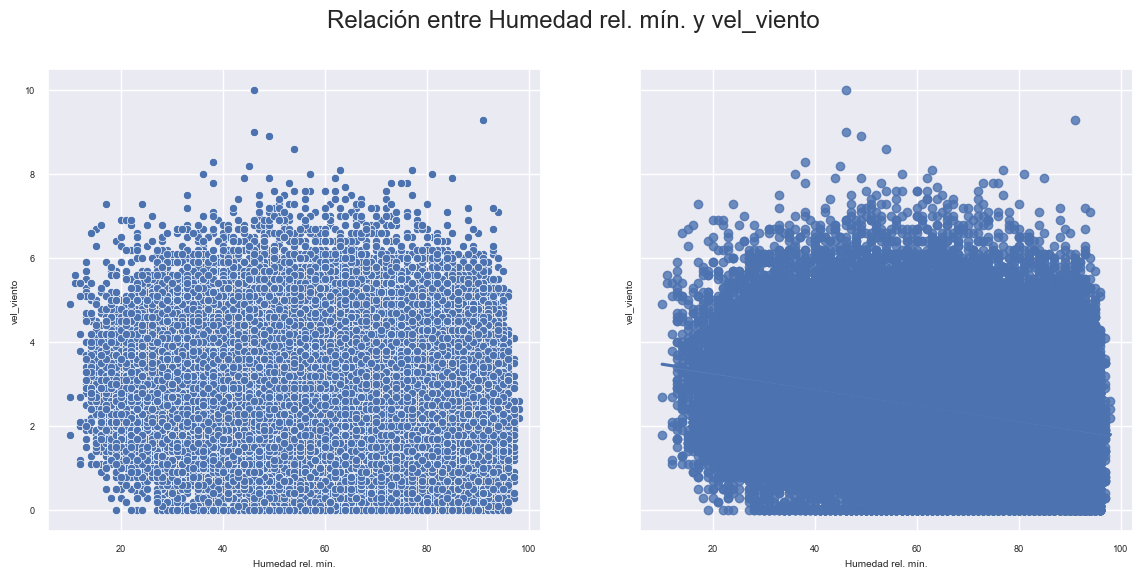

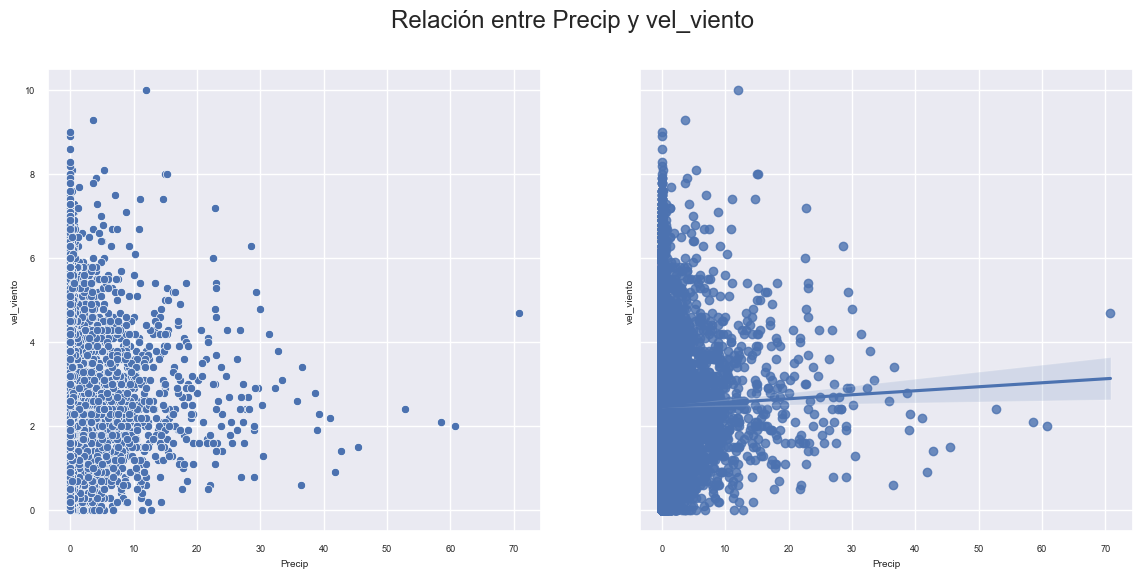

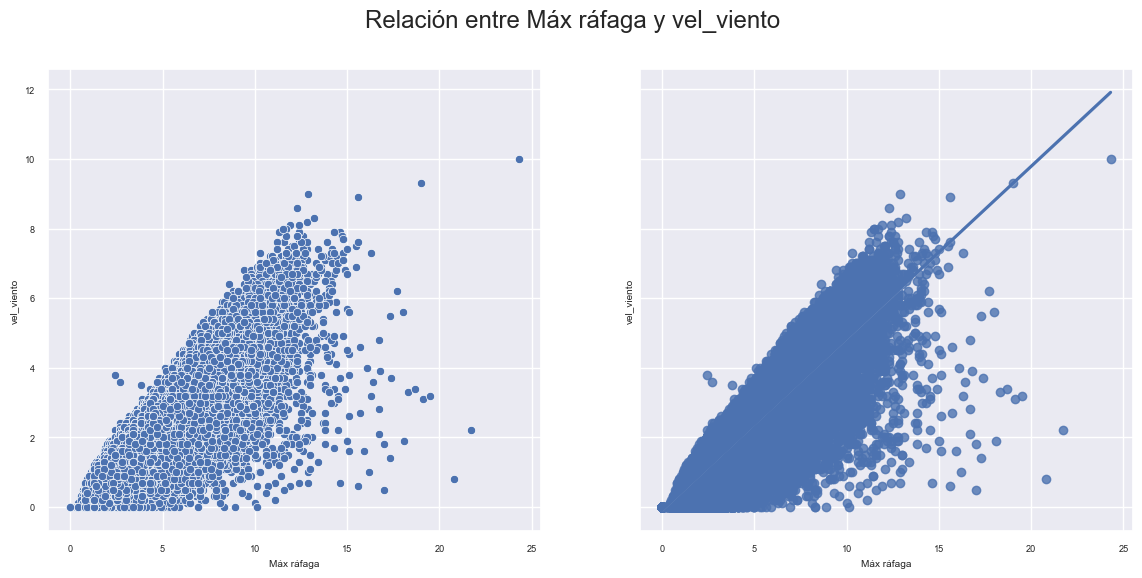

In [340]:
sns.pairplot(data=wind_merge);

num_cols = wind_merge.select_dtypes(include=np.number).columns.tolist()

def scatter_regplot(data, strx, stry):
    sns.set(font_scale=0.6)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.scatterplot(data=data, x=strx, y=stry, ax=ax[0])
    sns.set(font_scale=1.2)
    sns.regplot(data=data, x=strx, y=stry, ax=ax[1]);
    fig.suptitle('Relación entre %s y vel_viento'%col)  

num_cols.remove('vel_viento')
for col in num_cols:
    scatter_regplot(wind_merge, col, 'vel_viento')

Como se puedo observar no se apreciar una correlacion entre la hora, la humedad relativa minima, la direccion del viento con la velocidad del viento. Por otro lado, se encuentra una correlación no muy elevada entre la precip y la vel del viento. Finalmente, Se aprecia una fuerte correlaccion entre la rafaga y la velocidad del viento, que probablemente nos ayude a encontrar la mejor regresión.

## Modelo de Clasificacion

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import mglearn

In [374]:
#X_fraud.to_csv('X_fraud_final.csv', index=False)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_fraud, y_fraud, test_size=0.25, random_state=0, stratify=y_fraud )

* Dado que es una serie desbalanceada como se pudo observar en el EDA, se usara StratifiedKFold que asegura que las proporciones de clases se mantengan en cada división de los datos
* Por otro lado, dado que este es un problema de clasificación con clases desequilibradas, se utilizara el AUC para la selección del modelo que es más significativo que el uso de accuracy.

* Se creara un dataframe para almacenar los resultados de los modelos.

In [152]:
data = {
    'Modelo': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'AUC': []
}

clasificacion_modelos = pd.DataFrame(data)


In [153]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def metricas_class(y_test, y_pred, y_prob, nombre_modelo):
    f1_sc = f1_score(y_test, y_pred)
    roc_auc_sc = roc_auc_score(y_test, y_prob)  # Utiliza roc_auc_score para calcular el AUC-ROC
    precision_sc = precision_score(y_test, y_pred)
    recall_sc = recall_score(y_test, y_pred)
    
    return {
        'Modelo': nombre_modelo,
        'F1-Score': f1_sc,
        'AUC': roc_auc_sc,  
        'Precision': precision_sc,
        'Recall': recall_sc
    }

    

### K-NN

In [154]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold


param_grid = {'kneighborsclassifier__n_neighbors': [1,2,3,4,6,8,10,12,14,15,16]}

pipe = make_pipeline(StandardScaler(), KNeighborsClassifier()) 

grid = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1, scoring='roc_auc')

grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 6, 8,
                                                               10, 12, 14, 15,
                                                               16]},
             scoring='roc_auc')

In [155]:
print(f"Mejor estimador:\n{grid.best_estimator_}")

Mejor estimador:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=16))])


In [383]:
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)[:, 1]

nueva_fila = metricas_class(y_test, y_pred, y_prob, 'k-NN')

clasificacion_modelos = pd.concat([clasificacion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)

#### Matriz de Confusión, Curva ROC

Confusion matrix:
[[24345    15]
 [  589    51]]


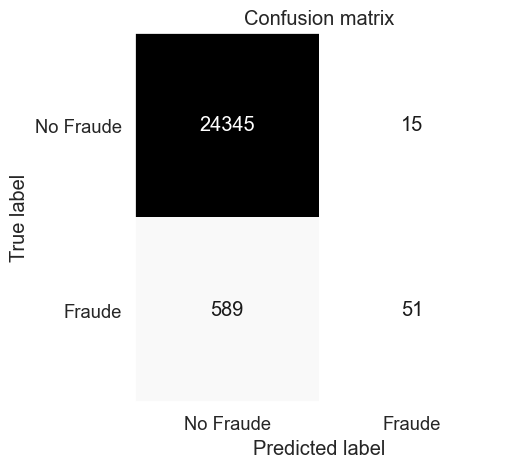

In [157]:
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, y_pred), 
                                     xlabel='Predicted label',
                                     ylabel='True label', 
                                     xticklabels=['No Fraude','Fraude'],
                                     yticklabels=['No Fraude','Fraude'], 
                                     cmap=plt.cm.gray_r, 
                                     fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

* Se observa que se predice la clase mas común que es Fraude, logra predecir algunos casos de fraude pero igualmente se equivoca bastante.

* Curva ROC

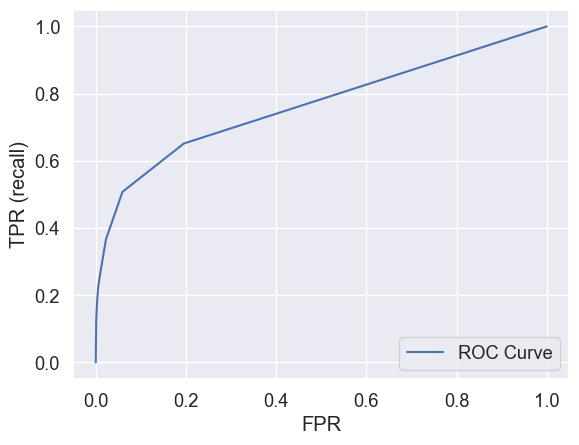

In [158]:
fpr, tpr, thresholds = roc_curve(y_test, grid.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_zero = np.argmin(np.abs(thresholds))
plt.legend(loc=4);

* La curva ROC no es la más adecuada, a pesar de obtenerse una precision del 83%, el recall fue muy bajo, mostrando el problema de que la serie sea desbalanceada.

In [159]:
clasificacion_modelos

Modelo  Precision    Recall  F1-Score       AUC
0   k-NN   0.772727  0.079687  0.144476  0.765427

### LogisticRegression

In [160]:
from sklearn.linear_model import LogisticRegression


# Definir el espacio de búsqueda de hiperparámetros para Logistic Regression
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Crear una tubería (pipeline) con StandardScaler y Logistic Regression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Utilizar validación cruzada estratificada
grid = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1, scoring='roc_auc')

# Ajustar el modelo Logistic Regression con búsqueda de hiperparámetros
grid.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100]},
             scoring='roc_auc')

In [161]:
print(f"Mejor estimador:\n{grid.best_estimator_}")

Mejor estimador:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.001))])


In [162]:
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)[:, 1]

nueva_fila = metricas_class(y_test, y_pred, y_prob, 'LogisticRegression')

clasificacion_modelos = pd.concat([clasificacion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)

#### Matriz de Confusión, Curva ROC

Confusion matrix:
[[24355     5]
 [  638     2]]


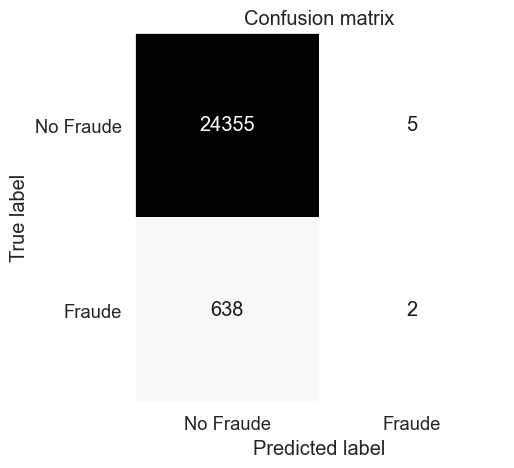

In [163]:
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, y_pred), 
                                     xlabel='Predicted label',
                                     ylabel='True label', 
                                     xticklabels=['No Fraude','Fraude'],
                                     yticklabels=['No Fraude','Fraude'], 
                                     cmap=plt.cm.gray_r, 
                                     fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

* Aqui observamos que no se predice casi nada a Fraude, tiene una tasa de falsos positivos bastante baja pero por que no predice casi nada como fraude, nos encontramos ante un modelo pesimo.

* Curva ROC

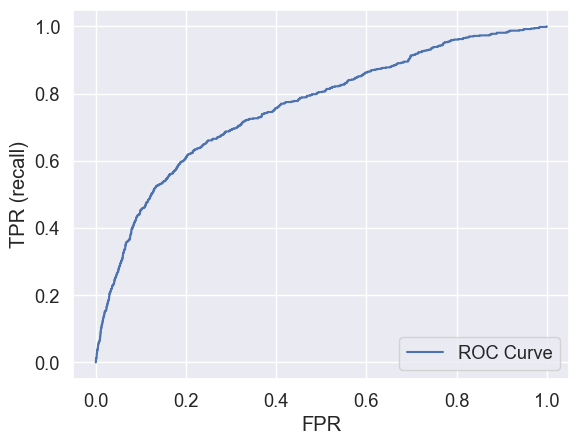

In [164]:
fpr, tpr, thresholds = roc_curve(y_test, grid.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_zero = np.argmin(np.abs(thresholds))
plt.legend(loc=4);

* Con este modelo obtenemos una curva ROC similar a k-NN, pero con un recall y F1 score aún peor, mostrando que no es modelo adecuado.

In [165]:
clasificacion_modelos

Modelo  Precision    Recall  F1-Score       AUC
0                k-NN   0.772727  0.079687  0.144476  0.765427
1  LogisticRegression   0.285714  0.003125  0.006182  0.758082

### Naive Bayes

In [166]:
from sklearn.naive_bayes import BernoulliNB  # Importa BernoulliNB en lugar de GaussianNB


# Crear una tubería (pipeline) con StandardScaler() y BernoulliNB()
pipe = make_pipeline(StandardScaler(), BernoulliNB())

# Definir el espacio de búsqueda de hiperparámetros para BernoulliNB
param_grid = {'bernoullinb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Utilizar validación cruzada estratificada
grid = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1, scoring='roc_auc')

# Ajustar el modelo BernoulliNB con búsqueda de hiperparámetros
grid.fit(X_train, y_train)



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('bernoullinb', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'bernoullinb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='roc_auc')

In [167]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('bernoullinb', BernoulliNB(alpha=0.001))])


In [168]:
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)[:, 1]

nueva_fila = metricas_class(y_test, y_pred, y_prob, 'Naive Bayes')

clasificacion_modelos = pd.concat([clasificacion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)

#### Matriz de Confusión, Curva ROC

Confusion matrix:
[[22770  1590]
 [  495   145]]


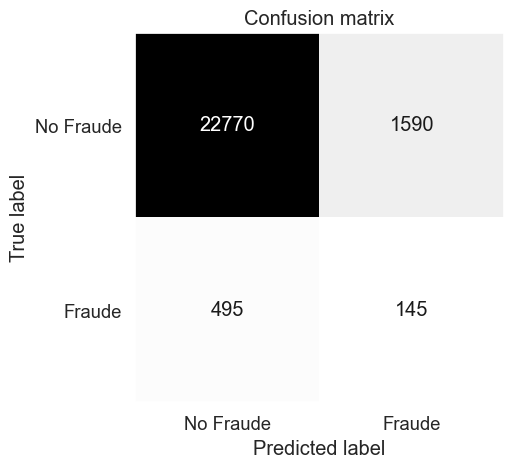

In [169]:
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, y_pred), 
                                     xlabel='Predicted label',
                                     ylabel='True label', 
                                     xticklabels=['No Fraude','Fraude'],
                                     yticklabels=['No Fraude','Fraude'], 
                                     cmap=plt.cm.gray_r, 
                                     fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

* Aqui observamos que hay un problema con precision, se esta realizando una gran cantidad de falsos positivos, predice algunas como fraude pero manda la gran parte a No Fraude.

* Curva ROC

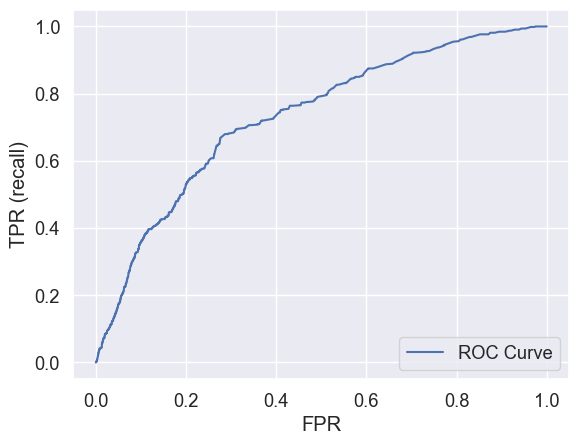

In [170]:
fpr, tpr, thresholds = roc_curve(y_test, grid.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_zero = np.argmin(np.abs(thresholds))
plt.legend(loc=4);

* Se obtiene una peor curva ROC pero aun asi un mejor Recall y F1-score que el modelo anterior, pero una precision tan pesima muestra lo malo que es el modelo.

In [171]:
clasificacion_modelos

Modelo  Precision    Recall  F1-Score       AUC
0                k-NN   0.772727  0.079687  0.144476  0.765427
1  LogisticRegression   0.285714  0.003125  0.006182  0.758082
2         Naive Bayes   0.083573  0.226562  0.122105  0.731815

### XGBoost

In [172]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


# Definir el espacio de búsqueda de hiperparámetros para XGBClassifier
param_grid = {
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__n_estimators': [100, 200, 300],
    'xgbclassifier__max_depth': [3, 4, 5],
}

# Crear un clasificador XGBClassifier
pipe = make_pipeline(MinMaxScaler(), XGBClassifier())

# Utilizar validación cruzada estratificada
grid = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1, scoring='roc_auc')

# Ajustar el modelo XGBClassifier con búsqueda de hiperparámetros
grid.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=N...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
                         'xgbclassifier__max_depth': [3, 4, 5],
                         'xgbclassifier__n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [173]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None

In [174]:
y_pred = grid.predict(X_test)
y_prob = grid.predict_proba(X_test)[:, 1]

nueva_fila = metricas_class(y_test, y_pred, y_prob, 'XGBoost')

clasificacion_modelos = pd.concat([clasificacion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)

#### Matriz de Confusión, Curva ROC

Confusion matrix:
[[24331    29]
 [  381   259]]


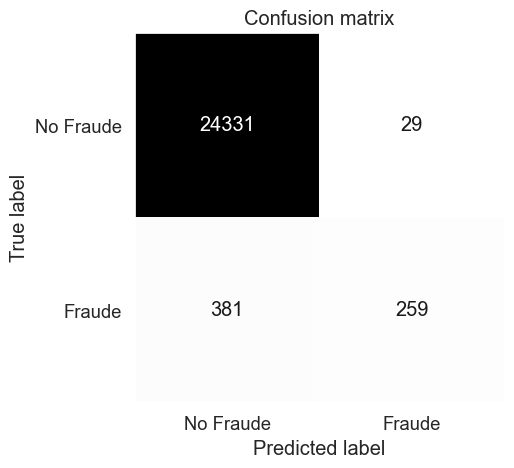

In [175]:
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, y_pred), 
                                     xlabel='Predicted label',
                                     ylabel='True label', 
                                     xticklabels=['No Fraude','Fraude'],
                                     yticklabels=['No Fraude','Fraude'], 
                                     cmap=plt.cm.gray_r, 
                                     fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

Aqui observamos que nos encontramos con un mejor modelo, predice una proporcion como Fraude cuando en realidad lo es, verdadera positiva, y casi no tiene falsos positivos, por lo que no se molestará a los clientes pensando que es fraude cuando en realidad no lo es.

* Curva ROC

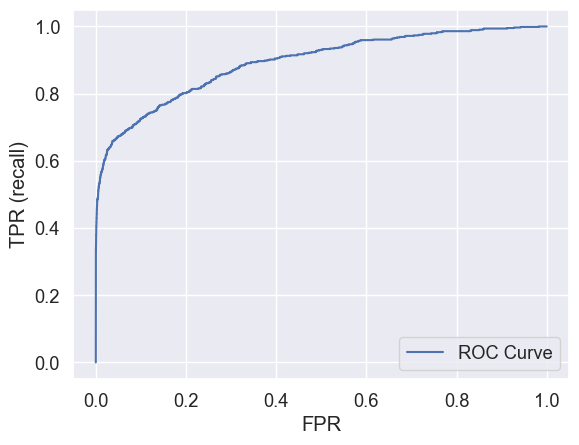

In [177]:
fpr, tpr, thresholds = roc_curve(y_test, grid.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_zero = np.argmin(np.abs(thresholds))
plt.legend(loc=4);

* Este modelo de Arboles de decisión demuestra un rendimiento superior a los anteriores modelos con todos los indicadores elevados y una curva ROC cercana a 1, vemos que podemos tener un recall alto con un FPR relativamente pequeño.

In [178]:
clasificacion_modelos

Modelo  Precision    Recall  F1-Score       AUC
0                k-NN   0.772727  0.079687  0.144476  0.765427
1  LogisticRegression   0.285714  0.003125  0.006182  0.758082
2         Naive Bayes   0.083573  0.226562  0.122105  0.731815
3             XGBoost   0.899306  0.404687  0.558190  0.893053

### SVM

In [179]:
from sklearn.svm import SVC

param_grid = [{'svc__kernel': ['rbf'],
               'svc__C': [0.01, 0.1, 1, 10, 100],
               'svc__gamma': [0.001, 0.01, 0.1, 1, 10]}]

"""param_grid = [{'svc__kernel': ['linear'],
               'svc__gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1]}]"""


pipe = make_pipeline(MinMaxScaler(), SVC())


# Utilizar validación cruzada estratificada
grid = GridSearchCV(pipe, param_grid, cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1, scoring='roc_auc')

# Ajustar el modelo con búsqueda de hiperparámetros
grid.fit(X_train, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid=[{'svc__C': [0.01, 0.1, 1, 10, 100],
                          'svc__gamma': [0.001, 0.01, 0.1, 1, 10],
                          'svc__kernel': ['rbf']}],
             scoring='roc_auc')

In [180]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(C=100, gamma=10))])


In [181]:
y_pred = grid.predict(X_test)
y_prob = grid.decision_function(X_test)

nueva_fila = metricas_class(y_test, y_pred, y_prob, 'SVM')

clasificacion_modelos = pd.concat([clasificacion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)

#### Matriz de Confusión, Curva ROC

Confusion matrix:
[[24258   102]
 [  436   204]]


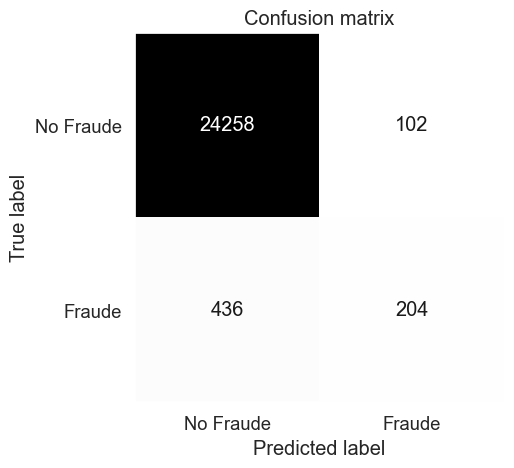

In [182]:
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, y_pred), 
                                     xlabel='Predicted label',
                                     ylabel='True label', 
                                     xticklabels=['No Fraude','Fraude'],
                                     yticklabels=['No Fraude','Fraude'], 
                                     cmap=plt.cm.gray_r, 
                                     fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

* Al igual que los modelos anteriores predice la clase más común, tiene una menor proporción de falsos positivos que verdaderos positivos es decir que al menos predice mejor que los modelos kNN y la regresión logistica.

* Curva ROC

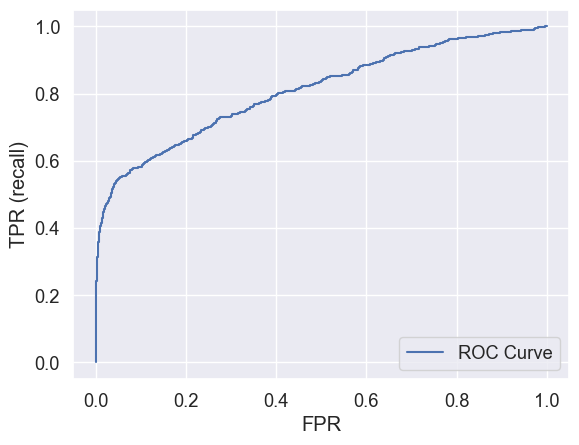

In [183]:
fpr, tpr, thresholds = roc_curve(y_test, grid.decision_function(X_test))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_zero = np.argmin(np.abs(thresholds))
plt.legend(loc=4);

* SVM muestra un peor rendimiento que el modelo anterior, quizá con un "C" mas alto se obtendria un mejor rendimiento pero por motivos computacionales este fue el rango de tuning utilizado. La curva ROC tiene un comportamiento similar a la del modelo k-NN, es necesario una mayor Tasa de Falsos Positivos para que aumente el recall.

In [184]:
clasificacion_modelos

Modelo  Precision    Recall  F1-Score       AUC
0                k-NN   0.772727  0.079687  0.144476  0.765427
1  LogisticRegression   0.285714  0.003125  0.006182  0.758082
2         Naive Bayes   0.083573  0.226562  0.122105  0.731815
3             XGBoost   0.899306  0.404687  0.558190  0.893053
4                 SVM   0.666667  0.318750  0.431290  0.809104

### MLP

In [185]:
from sklearn.neural_network import MLPClassifier


param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlpclassifier__activation': ['relu', 'tanh'],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01, 0.1],
}

# Crear un modelo MLPClassifier
pipe = make_pipeline(MinMaxScaler(), MLPClassifier())

# Crear un objeto GridSearchCV para buscar hiperparámetros
grid_search = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1, scoring='roc_auc')

# Ajustar el modelo y buscar la mejor combinación de hiperparámetros
grid_search.fit(X_fraud, y_fraud)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('mlpclassifier', MLPClassifier())]),
             n_jobs=-1,
             param_grid={'mlpclassifier__activation': ['relu', 'tanh'],
                         'mlpclassifier__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'mlpclassifier__hidden_layer_sizes': [(50,), (100,),
                                                               (50, 50)]},
             scoring='roc_auc')

In [186]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('mlpclassifier', MLPClassifier())])


In [187]:
y_pred = grid_search.predict(X_test)
y_prob = grid_search.predict_proba(X_test)[:, 1]

nueva_fila = metricas_class(y_test, y_pred, y_prob,'MLP')

clasificacion_modelos = pd.concat([clasificacion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)

#### Matriz de Confusión, Curva ROC

Confusion matrix:
[[24336    24]
 [  460   180]]


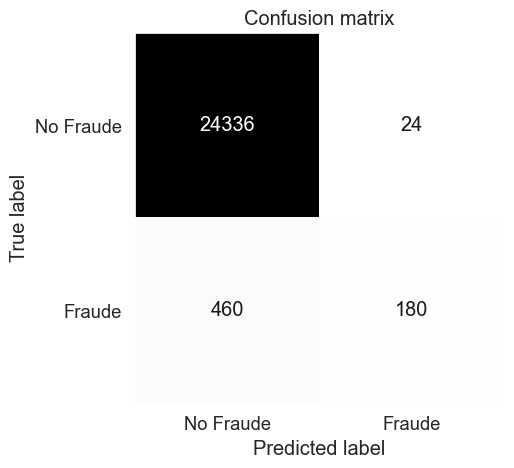

In [188]:
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

scores_image = mglearn.tools.heatmap(confusion_matrix(y_test, y_pred), 
                                     xlabel='Predicted label',
                                     ylabel='True label', 
                                     xticklabels=['No Fraude','Fraude'],
                                     yticklabels=['No Fraude','Fraude'], 
                                     cmap=plt.cm.gray_r, 
                                     fmt="%d")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

* Este modelo al igual que el XGBoost muestra uno de los mejores rendimientos teniendo pocos falsos positivos y falsos negativos, puede mejorar probando mas hiperparametros.

* Curva ROC

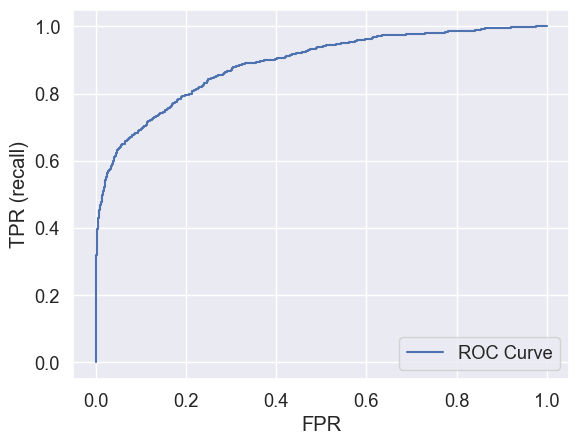

In [189]:
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
close_zero = np.argmin(np.abs(thresholds))
plt.legend(loc=4);

* Se observa que la curva ROC se acerca bastante a ser un rectangulo que es el objetivo, obteniendo una curva bastante similar al modelo XGBoost.Cercana al objetivo que es 1.

### Resultados del Modelo de clasificación

* Observamos que el mejor resultado se obtuvo con XGBoost para todos los parametros, seguido de MLP y posteriormente SVM. El modelo que dio el peor resultado fue Naive Bayes para el parametro a maximizar que era el AUC. El MLP tenia potencial de superar al XGBoost pero debido a motivos computacionales no se pudo probar con otras combinaciones de sus hiperparametros.

In [190]:
clasificacion_modelos

Modelo  Precision    Recall  F1-Score       AUC
0                k-NN   0.772727  0.079687  0.144476  0.765427
1  LogisticRegression   0.285714  0.003125  0.006182  0.758082
2         Naive Bayes   0.083573  0.226562  0.122105  0.731815
3             XGBoost   0.899306  0.404687  0.558190  0.893053
4                 SVM   0.666667  0.318750  0.431290  0.809104
5                 MLP   0.882353  0.281250  0.426540  0.888710

* En este caso, se tomaria el modelo XGBoost ofrecen los mejores recall y F1 score, y se maximiza el AUC.

## Modelo de regresion

* Se importan las librerias necesarias para el problema de regresión

In [341]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

* Se separa la variable a predecir de las demas.

In [342]:
X_wind = X_wind
y_wind = wind_speed[['vel_viento']].copy()

In [343]:
X_wind_c = X_wind
y_wind_c = y_wind

In [344]:
def metrica(y_test, y_pred):
    # Calcular el RRMSE directamente
    mse = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mse)
    
    return RMSE

* Se separan los datos en test, que no se tocaran solo hasta el final para evaluar el modelo, y en datos de entrenamiento y validacion para comprobar que modelo es mejor.

In [345]:
y_wind_test = y_wind.tail(24)
y_wind_test = np.array(y_wind_test)
y_wind_trainval = y_wind[:-24]
X_wind_test = X_wind.tail(24)
X_wind_trainval = X_wind[:-24]

* Se establece un dataframe donde se guardara los resultados de cada modelo

In [346]:
#Crear un DataFrame inicial con columnas
data = {'Modelo': [],
        'MAPE':[],
        'RMSE':[],
        'R2': []}

regresion_modelos = pd.DataFrame(data)

* Se establecera el numero de Folds, en este caso se haran 100 fold de entrenamiento y validación para escoger los hiperparametros que produzcan un menor RMSE.

In [347]:
#n_folds = int(len(y_wind_trainval) / (24))

n_folds = 100

#### Metricas

In [348]:

def metricas_completas(y_test, y_pred):
    
    # 1. Calcula el error absoluto porcentual (APE)
    APE = np.abs((y_test - y_pred) / y_test) * 100

    # 2. Calcula el MAPE promediando los APEs
    MAPE = np.mean(APE)
    
    mse = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mse)
    
    # Calcular R-squared
    r2 = r2_score(y_test, y_pred)
    # print(f"R-squared (R^2): {r2:.2f}")
    
    return MAPE, RMSE, r2
    
    

### K-NN

* En primer lugar se utilizo el modelo k-NN, tomando desde 3 a 23 vecinos cercanos para obtener cual era el numero optimo.

* Observamos que hemos definido una función para aumentar progresivamente el número de divisiones en los conjuntos de entrenamiento y validación, con el objetivo de seleccionar aquel que resulte en un RMSE promedio más bajo.

In [349]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from itertools import product

# Valores de hiperparámetros de k-NN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23],  # Número de vecinos

}

combinations = list(product(*param_grid.values()))  # Todas las combinaciones

valores_rmse = []

for combination in combinations:
    rmse_list = []
    for j in range(n_folds):
        i = (j + 1) * 24
        X_wind_train = X_wind_trainval[:i]
        y_wind_train = y_wind_trainval[:i]
        X_wind_val = X_wind_trainval[i:i + 24]
        y_wind_val = y_wind_trainval[i:i + 24]

        # Crear un modelo k-NN con la combinación actual de hiperparámetros
        params = dict(zip(param_grid.keys(), combination))
        model = Pipeline([
            ('scaler', StandardScaler()),  # Estándarización
            ('knn', KNeighborsRegressor(**params))  # Modelo k-NN
        ])
        model.fit(X_wind_train, y_wind_train)
        y_pred = model.predict(X_wind_val)

        # Calcular el RMSE para esta ventana
        rmse = metrica(y_wind_val, y_pred)

        rmse_list.append(rmse)

    # Calcula la media de los RMSE de las particiones de validación cruzada
    mean_rmse = np.mean(rmse_list)

    valores_rmse.append((params, mean_rmse))

# Encuentra la combinación de hiperparámetros con el RMSE más bajo
best_params, best_rmse = min(valores_rmse, key=lambda x: x[1])

# Crea el modelo k-NN con los mejores hiperparámetros
best_model = Pipeline([
    ('scaler', StandardScaler()),  # Estándarización
    ('knn', KNeighborsRegressor(**best_params))  # Modelo k-NN
])
best_model.fit(X_wind_trainval, y_wind_trainval)
y_pred = best_model.predict(X_wind_test)

# Calcular el MAPE, RMSE y R2 en el conjunto de prueba
MAPE, RMSE, R2 = metricas_completas(y_wind_test, y_pred)

nueva_fila = {'Modelo': 'k-NN', 'MAPE': MAPE, 'RMSE': RMSE, 'R2': R2}
regresion_modelos = pd.concat([regresion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)

* A continuación se muestran los mejores hiperparametros.

In [350]:
best_params, best_rmse

({'n_neighbors': 19}, 0.6233136061992812)

In [351]:
regresion_modelos

Modelo      MAPE      RMSE        R2
0   k-NN  15.45046  0.708462  0.772881

### Ridge

* Para el modelo Ridge al igual que más adelante con el modelo Lasso, se generaron 100 alphas para probar el mejor ajuste.

In [352]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from itertools import product

n_alphas = 100
alphas = np.logspace(-10, -2, n_alphas)

# Valores de hiperparámetros de Ridge
param_grid = {
    'alpha': alphas,  # Parámetro de regularización
}

combinations = list(product(*param_grid.values()))  # Todas las combinaciones

valores_rmse = []

for combination in combinations:
    rmse_list = []
    for j in range(n_folds):
        i = (j + 1) * 24
        X_wind_train = X_wind_trainval[:i]
        y_wind_train = y_wind_trainval[:i]
        X_wind_val = X_wind_trainval[i:i + 24]
        y_wind_val = y_wind_trainval[i:i + 24]

        # Crear un modelo Ridge con la combinación actual de hiperparámetros
        params = dict(zip(param_grid.keys(), combination))
        model = Pipeline([
            ('scaler', StandardScaler()),  # Estándarización
            ('ridge', Ridge(**params))  # Modelo Ridge
        ])
        model.fit(X_wind_train, y_wind_train)
        y_pred = model.predict(X_wind_val)

        # Calcular el RMSE para esta ventana
        rmse = metrica(y_wind_val, y_pred)

        rmse_list.append(rmse)

    # Calcula la media de los RMSE de las particiones de validación cruzada
    mean_rmse = np.mean(rmse_list)

    valores_rmse.append((params, mean_rmse))

# Encuentra la combinación de hiperparámetros con el RMSE más bajo
best_params, best_rmse = min(valores_rmse, key=lambda x: x[1])

# Crea el modelo Ridge con los mejores hiperparámetros
best_model = Pipeline([
    ('scaler', StandardScaler()),  # Estándarización
    ('ridge', Ridge(**best_params))  # Modelo Ridge
])
best_model.fit(X_wind_trainval, y_wind_trainval)
y_pred = best_model.predict(X_wind_test)

# Calcular el MAPE, RMSE y R2 en el conjunto de prueba
MAPE, RMSE, R2 = metricas_completas(y_wind_test, y_pred)

nueva_fila = {'Modelo': 'Ridge', 'MAPE': MAPE, 'RMSE': RMSE, 'R2': R2}
regresion_modelos = pd.concat([regresion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)

        

In [353]:
best_params, best_rmse

({'alpha': 0.01}, 0.5528443964933503)

In [354]:
regresion_modelos

Modelo       MAPE      RMSE        R2
0   k-NN  15.450460  0.708462  0.772881
1  Ridge  16.302087  0.610532  0.831330

### Lasso

* Igualmente se aplico el modelo Lasso, el cual puede llegar a reducir las variables hasta 0, si observa que no aportan al modelo. Para este caso se probaron 100 alphas.

In [355]:
from sklearn.linear_model import Lasso


n_alphas = 100
alphas = np.logspace(-10, -2, n_alphas)

# Valores de hiperparámetros de Lasso
param_grid = {
    'alpha': alphas,  # Parámetro de regularización
}

combinations = list(product(*param_grid.values()))  # Todas las combinaciones

valores_rmse = []

for combination in combinations:
    rmse_list = []
    for j in range(n_folds):
        i = (j + 1) * 24
        X_wind_train = X_wind_trainval[:i]
        y_wind_train = y_wind_trainval[:i]
        X_wind_val = X_wind_trainval[i:i + 24]
        y_wind_val = y_wind_trainval[i:i + 24]

        # Crear un modelo Lasso con la combinación actual de hiperparámetros
        params = dict(zip(param_grid.keys(), combination))
        model = Pipeline([
            ('scaler', StandardScaler()),  # Estándarización
            ('lasso', Lasso(**params))  # Modelo Lasso
        ])
        model.fit(X_wind_train, y_wind_train)
        y_pred = model.predict(X_wind_val)

        # Calcular el RMSE para esta ventana
        rmse = metrica(y_wind_val, y_pred)

        rmse_list.append(rmse)

    # Calcula la media de los RMSE de las particiones de validación cruzada
    mean_rmse = np.mean(rmse_list)

    valores_rmse.append((params, mean_rmse))

# Encuentra la combinación de hiperparámetros con el RMSE más bajo
best_params, best_rmse = min(valores_rmse, key=lambda x: x[1])

# Crea el modelo Lasso con los mejores hiperparámetros
best_model = Pipeline([
    ('scaler', StandardScaler()),  # Estándarización
    ('lasso', Lasso(**best_params))  # Modelo Lasso
])
best_model.fit(X_wind_trainval, y_wind_trainval)
y_pred = best_model.predict(X_wind_test)

# Calcular el MAPE, RMSE y R2 en el conjunto de prueba
MAPE, RMSE, R2 = metricas_completas(y_wind_test, y_pred)

nueva_fila = {'Modelo': 'Lasso', 'MAPE': MAPE, 'RMSE': RMSE, 'R2': R2}
regresion_modelos = pd.concat([regresion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)

In [356]:
best_params, best_rmse

({'alpha': 0.00689261210434971}, 0.5522048200928098)

In [357]:
regresion_modelos

Modelo       MAPE      RMSE        R2
0   k-NN  15.450460  0.708462  0.772881
1  Ridge  16.302087  0.610532  0.831330
2  Lasso  49.951102  0.612398  0.830297

### XGBoost

* Para xgboost se utilizo su libreria independiente que actualmente es más rápida, y se definierón algunos parametros de prepoda del arbol como el max_depth,  para encontrar el mejor ajuste.

In [358]:
import xgboost as xgb

from itertools import product  # Para generar todas las combinaciones

# Valores de hiperparámetros de XGBoost y alphas
alphas = [0.01, 0.1, 1.0]  # Agrega los valores de alphas que desees
param_grid = {
    'n_estimators': [100, 200],      # Número de árboles
    'learning_rate': [0.1, 0.01],   # Tasa de aprendizaje
    'max_depth': [3, 4],            # Profundidad máxima del árbol
    'alpha': alphas                  # Parámetro de regularización L1
}

combinations = list(product(*param_grid.values()))  # Todas las combinaciones

valores_rmse = []

for combination in combinations:
    rmse_list = []
    for j in range(n_folds):
        i = (j + 1) * 24
        X_wind_train = X_wind_trainval[:i]
        y_wind_train = y_wind_trainval[:i]
        X_wind_val = X_wind_trainval[i:i + 24]
        y_wind_val = y_wind_trainval[i:i + 24]

        # Crear un modelo XGBoost con la combinación actual de hiperparámetros
        params = dict(zip(param_grid.keys(), combination))
        model = Pipeline([
            ('scaler', StandardScaler()),  # Estándarización
            ('xgb', xgb.XGBRegressor(**params))  # Modelo XGBoost
        ])
        model.fit(X_wind_train, y_wind_train)
        y_pred = model.predict(X_wind_val)

        # Calcular el RMSE para esta ventana
        rmse = metrica(y_wind_val, y_pred)

        rmse_list.append(rmse)


    # Calcula la media de los RMSE de las particiones de validación cruzada
    mean_rmse = np.mean(rmse_list)

    valores_rmse.append((params, mean_rmse))

# Encuentra la combinación de hiperparámetros con el RMSE más bajo
best_params, best_rmse = min(valores_rmse, key=lambda x: x[1])

# Crea el modelo XGBoost con los mejores hiperparámetros
best_model = Pipeline([
    ('scaler', StandardScaler()),  # Estándarización
    ('xgb', xgb.XGBRegressor(**best_params))  # Modelo XGBoost
])
best_model.fit(X_wind_trainval, y_wind_trainval)
y_pred = best_model.predict(X_wind_test)

# Calcular el MAPE, RMSE y R2 en el conjunto de prueba
MAPE, RMSE, R2 = metricas_completas(y_wind_test, y_pred)

nueva_fila = {'Modelo': 'XGBoost', 'MAPE': MAPE, 'RMSE': RMSE, 'R2': R2}
regresion_modelos = pd.concat([regresion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)


In [359]:
best_params, best_rmse

({'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'alpha': 1.0},
 0.5608837210434533)

In [360]:
regresion_modelos

Modelo       MAPE      RMSE        R2
0     k-NN  15.450460  0.708462  0.772881
1    Ridge  16.302087  0.610532  0.831330
2    Lasso  49.951102  0.612398  0.830297
3  XGBoost  45.824291  0.775558  0.727824

### SVR

* Para el SVR se probo con dos kernel, el lineal y el rbf, para obtener los mejores ajustes de los hiperparametros.

In [361]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from itertools import product

# Valores de hiperparámetros de SVR
param_grid = {
    'C': [0.1, 1.0, 10.0],          # Parámetro de regularización
    'epsilon': [0.1, 0.01, 0.001],  # Tolerancia de error
    'kernel': ['linear', 'rbf']     # Tipo de kernel (lineal o RBF)
}

combinations = list(product(*param_grid.values()))  # Todas las combinaciones

valores_rmse = []

for combination in combinations:
    rmse_list = []
    for j in range(n_folds):
        i = (j + 1) * 24
        X_wind_train = X_wind_trainval[:i]
        y_wind_train = y_wind_trainval[:i]
        X_wind_val = X_wind_trainval[i:i + 24]
        y_wind_val = y_wind_trainval[i:i + 24]

        # Crear un modelo SVR con la combinación actual de hiperparámetros
        params = dict(zip(param_grid.keys(), combination))
        model = Pipeline([
            ('scaler', MinMaxScaler()),  # Estandarización con MinMaxScaler
            ('svr', SVR(**params))       # Modelo SVR
        ])
        model.fit(X_wind_train, y_wind_train)
        y_pred = model.predict(X_wind_val)

        # Calcular el RMSE para esta ventana
        rmse = metrica(y_wind_val, y_pred)

        rmse_list.append(rmse)


    # Calcula la media de los RMSE de las particiones de validación cruzada
    mean_rmse = np.mean(rmse_list)

    valores_rmse.append((params, mean_rmse))

# Encuentra la combinación de hiperparámetros con el RMSE más bajo
best_params, best_rmse = min(valores_rmse, key=lambda x: x[1])

# Crea el modelo SVR con los mejores hiperparámetros
best_model = Pipeline([
    ('scaler', MinMaxScaler()),  # Estandarización con MinMaxScaler
    ('svr', SVR(**best_params))  # Modelo SVR
])
best_model.fit(X_wind_trainval, y_wind_trainval)
y_pred = best_model.predict(X_wind_test)

# Calcular el MAPE, RMSE y R2 en el conjunto de prueba
MAPE, RMSE, R2 = metricas_completas(y_wind_test, y_pred)

nueva_fila = {'Modelo': 'SVR', 'MAPE': MAPE, 'RMSE': RMSE, 'R2': R2}
regresion_modelos = pd.concat([regresion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)


In [362]:
best_params, best_rmse

({'C': 10.0, 'epsilon': 0.01, 'kernel': 'linear'}, 0.552519468601639)

In [363]:
regresion_modelos

Modelo       MAPE      RMSE        R2
0     k-NN  15.450460  0.708462  0.772881
1    Ridge  16.302087  0.610532  0.831330
2    Lasso  49.951102  0.612398  0.830297
3  XGBoost  45.824291  0.775558  0.727824
4      SVR  51.485145  0.558294  0.858958

### MLP

* Aqui se crea el EarlyStopping, el cual detendra el proceso de aprendizaje de la red neunoral cuando no mejore la perdida, Loss.

In [364]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

* Finalmente para el método de MLP se estableció como 10 folds, y se toma el modelo que de un mejor RMSE, se hizo prueba de diferentes configuraciones de las hidden layer.

In [368]:

import tensorflow as tf

# Valores de hiperparámetros de MLP
param_grid = {
    'hidden_layer_sizes': [(64,64,64), (64,128,128), (64,64,128), (128,128,128)],
    'activation': ['relu','tanh'],
}

combinations = list(product(*param_grid.values()))

valores_rmse = []

for combination in combinations:
    rmse_list = []
    for j in range(int(n_folds/5)):
        i = (j + 1) * 24
        X_wind_train = X_wind_trainval[:i]
        y_wind_train = y_wind_trainval[:i]
        X_wind_val = X_wind_trainval[i:i + 24]
        y_wind_val = y_wind_trainval[i:i + 24]

        # Crear un modelo MLP con la combinación actual de hiperparámetros
        params = dict(zip(param_grid.keys(), combination))
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(X_wind_train.shape[1],)),
            tf.keras.layers.Dense(units=params['hidden_layer_sizes'][0], activation=params['activation']),
            tf.keras.layers.Dense(units=params['hidden_layer_sizes'][1], activation=params['activation']),
            tf.keras.layers.Dense(units=params['hidden_layer_sizes'][2], activation=params['activation']),

            tf.keras.layers.Dense(1)
        ])

        model.compile(optimizer='adam', loss='mean_squared_error')

        scaler = MinMaxScaler()
        X_wind_train_scaled = scaler.fit_transform(X_wind_train)
        X_wind_val_scaled = scaler.transform(X_wind_val)

        model.fit(X_wind_train_scaled, y_wind_train, epochs=100, batch_size=128, verbose=0, callbacks=[early_stopping])

        y_pred = model.predict(X_wind_val_scaled)
        rmse_value = metrica(y_wind_val, y_pred)
        rmse_list.append(rmse_value)
        print(j)

    # Calcula la media de los RMSE de las particiones de validación cruzada
    mean_rmse = np.mean(rmse_list)
    valores_rmse.append((params, mean_rmse))

# Encuentra la combinación de hiperparámetros con el RMSE más bajo
best_params, best_rmse = min(valores_rmse, key=lambda x: x[1])

# Entrena el modelo MLP con los mejores hiperparámetros en todo el conjunto de entrenamiento
best_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_wind_trainval.shape[1],)),
    tf.keras.layers.Dense(units=best_params['hidden_layer_sizes'][0], activation=best_params['activation']),
    tf.keras.layers.Dense(units=best_params['hidden_layer_sizes'][1], activation=best_params['activation']),
    tf.keras.layers.Dense(units=params['hidden_layer_sizes'][2], activation=params['activation']),
    tf.keras.layers.Dense(1)
])

best_model.compile(optimizer='adam', loss='mean_squared_error')

scaler = MinMaxScaler()
X_wind_trainval_scaled = scaler.fit_transform(X_wind_trainval)
X_wind_test_scaled = scaler.transform(X_wind_test)

best_model.fit(X_wind_trainval_scaled, y_wind_trainval, epochs=100, batch_size=512, verbose=1, callbacks=[early_stopping])

# Realiza predicciones en el conjunto de prueba
y_pred = best_model.predict(X_wind_test_scaled)

# Calcular el MAPE, RMSE y R2 en el conjunto de prueba
MAPE, RMSE, R2 = metricas_completas(y_wind_test, y_pred)

nueva_fila = {'Modelo': 'MLP', 'MAPE': MAPE, 'RMSE': RMSE, 'R2': R2}
regresion_modelos = pd.concat([regresion_modelos, pd.DataFrame([nueva_fila])], ignore_index=True)


1/1 [==============================] - 0s 168ms/step
0
1/1 [==============================] - 0s 185ms/step
1
1/1 [==============================] - 0s 262ms/step
2
1/1 [==============================] - 0s 196ms/step
3
1/1 [==============================] - 0s 131ms/step
4
1/1 [==============================] - 0s 211ms/step
5
1/1 [==============================] - 0s 215ms/step
6
1/1 [==============================] - 0s 182ms/step
7
1/1 [==============================] - 0s 147ms/step
8
1/1 [==============================] - 0s 248ms/step
9
1/1 [==============================] - 0s 196ms/step
10
1/1 [==============================] - 0s 172ms/step
11
1/1 [==============================] - 0s 186ms/step
12
1/1 [==============================] - 0s 203ms/step
13
1/1 [==============================] - 0s 302ms/step
14
1/1 [==============================] - 0s 164ms/step
15
1/1 [==============================] - 0s 144ms/step
16
1/1 [==============================] - 0s 164ms/step
17
1/

In [369]:
best_params, best_rmse

({'hidden_layer_sizes': (128, 128, 128), 'activation': 'tanh'},
 0.5753456379507959)

### Resultados de modelos de regresión

* Finalmente el mejor módelo de los obtenidos es el SVR, probablemente el MLP podría haber obtenido un rendimiento superior si se hubiera probado con más capas o otra configuración de la red e igualmente probando con mas folds, en este caso solo se probo con 20 folds. Utilizando un mayor número posiblemente se encontraría una mejor configuración.

In [372]:
regresion_modelos 

Modelo       MAPE      RMSE        R2
0     k-NN  15.450460  0.708462  0.772881
1    Ridge  16.302087  0.610532  0.831330
2    Lasso  49.951102  0.612398  0.830297
3  XGBoost  45.824291  0.775558  0.727824
4      SVR  51.485145  0.558294  0.858958
6      MLP  16.213585  0.739880  0.752290

* El mejor modelo fue el SVR seguidos de Ridge y Lasso. Estos mostraron un rendimiento por encima de 0.8 para el R2, segun los estandares un R2 superior a 0.7 es aceptable y todos mostraron un valor por encima de este.